# Week 13

### Topic
 1. Review gaussian mixture models and KNN for classification
 1. Calculating train and test errors with access to the underlying population
 1. TO SLIDES TO TALK ABOUT CROSS VALIDATION (CV)
 1. k-fold Cross Validation
 1. CV with tuning function
 1. TO SLIDES TO TALK ABOUT BOOTSTRAPPING
 1. Bootstrapping with tuning function


In [1]:
# resize
require(repr)
options(repr.plot.width=10, repr.plot.height=8, repr.plot.res=300)

Loading required package: repr



## 1. Review gaussian mixture models and KNN for classification -- this is in the starter R file

RECALL: to probe KNN we will do this in steps
  1. generate some "fake" sample data from a known distribution
  2. use this fake data to "train" our KNN
  3. we can see how well we do/try to calculate the boundary between 2 distributions
  4. Now this week: we'll start quantifying the test/training errors on this simulated dataset
  5. we'll explore validatian methods (assuming we don't know anything about the underlying population/model)

Let's upload all the package we had to install last time:

In [2]:
#install.packages("mvtnorm") # run once
#install.packages("flexclust") # run once

library(dplyr)
library(mvtnorm)
library(flexclust)
library(class)
library(tidyverse)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4

── Attaching packages ─────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



We'll also be using some helpful scripts from the STOR390 GitHub page:

In [3]:
source('https://raw.githubusercontent.com/idc9/stor390/master/notes/cross_validation/synthetic_distributions.R')
source('https://raw.githubusercontent.com/idc9/stor390/master/notes/cross_validation/knn_functions.R')

RECALL: we will now draw points from 2D gaussians, i.e. normal distributions one gaussian will be tagged as "1", the other as "-1".

We made 2 random choices:
 1. where the center of each gaussian/normal distribution is
 2. x1 & x2 coordinates

For this example, we're going to make a "fake" population to choose a sample from:
 * a *population* of 2 classified datasets based on a 2 randomly placed gaussians
 
Let's make our "fake" population (assume this ALL possible points from the background population):

In [24]:
# first, we fix the "mean seed" so this chooses where each 2D gaussian is placed
mean_seed = 238

# If we recall to last week, to get the same distribution every time, we need to 
#  have the same means & the same random drawing, we fix this with:
data_seed = 53272

# then for our underlying simulated population, lets take 2000 points of pos & 2000 points of neg
n_neg = 2000
n_pos = 2000

fake_pop_data = gmm_distribution2d(n_neg=n_neg, n_pos=n_pos, mean_seed=mean_seed, data_seed=data_seed)

Let's plot:

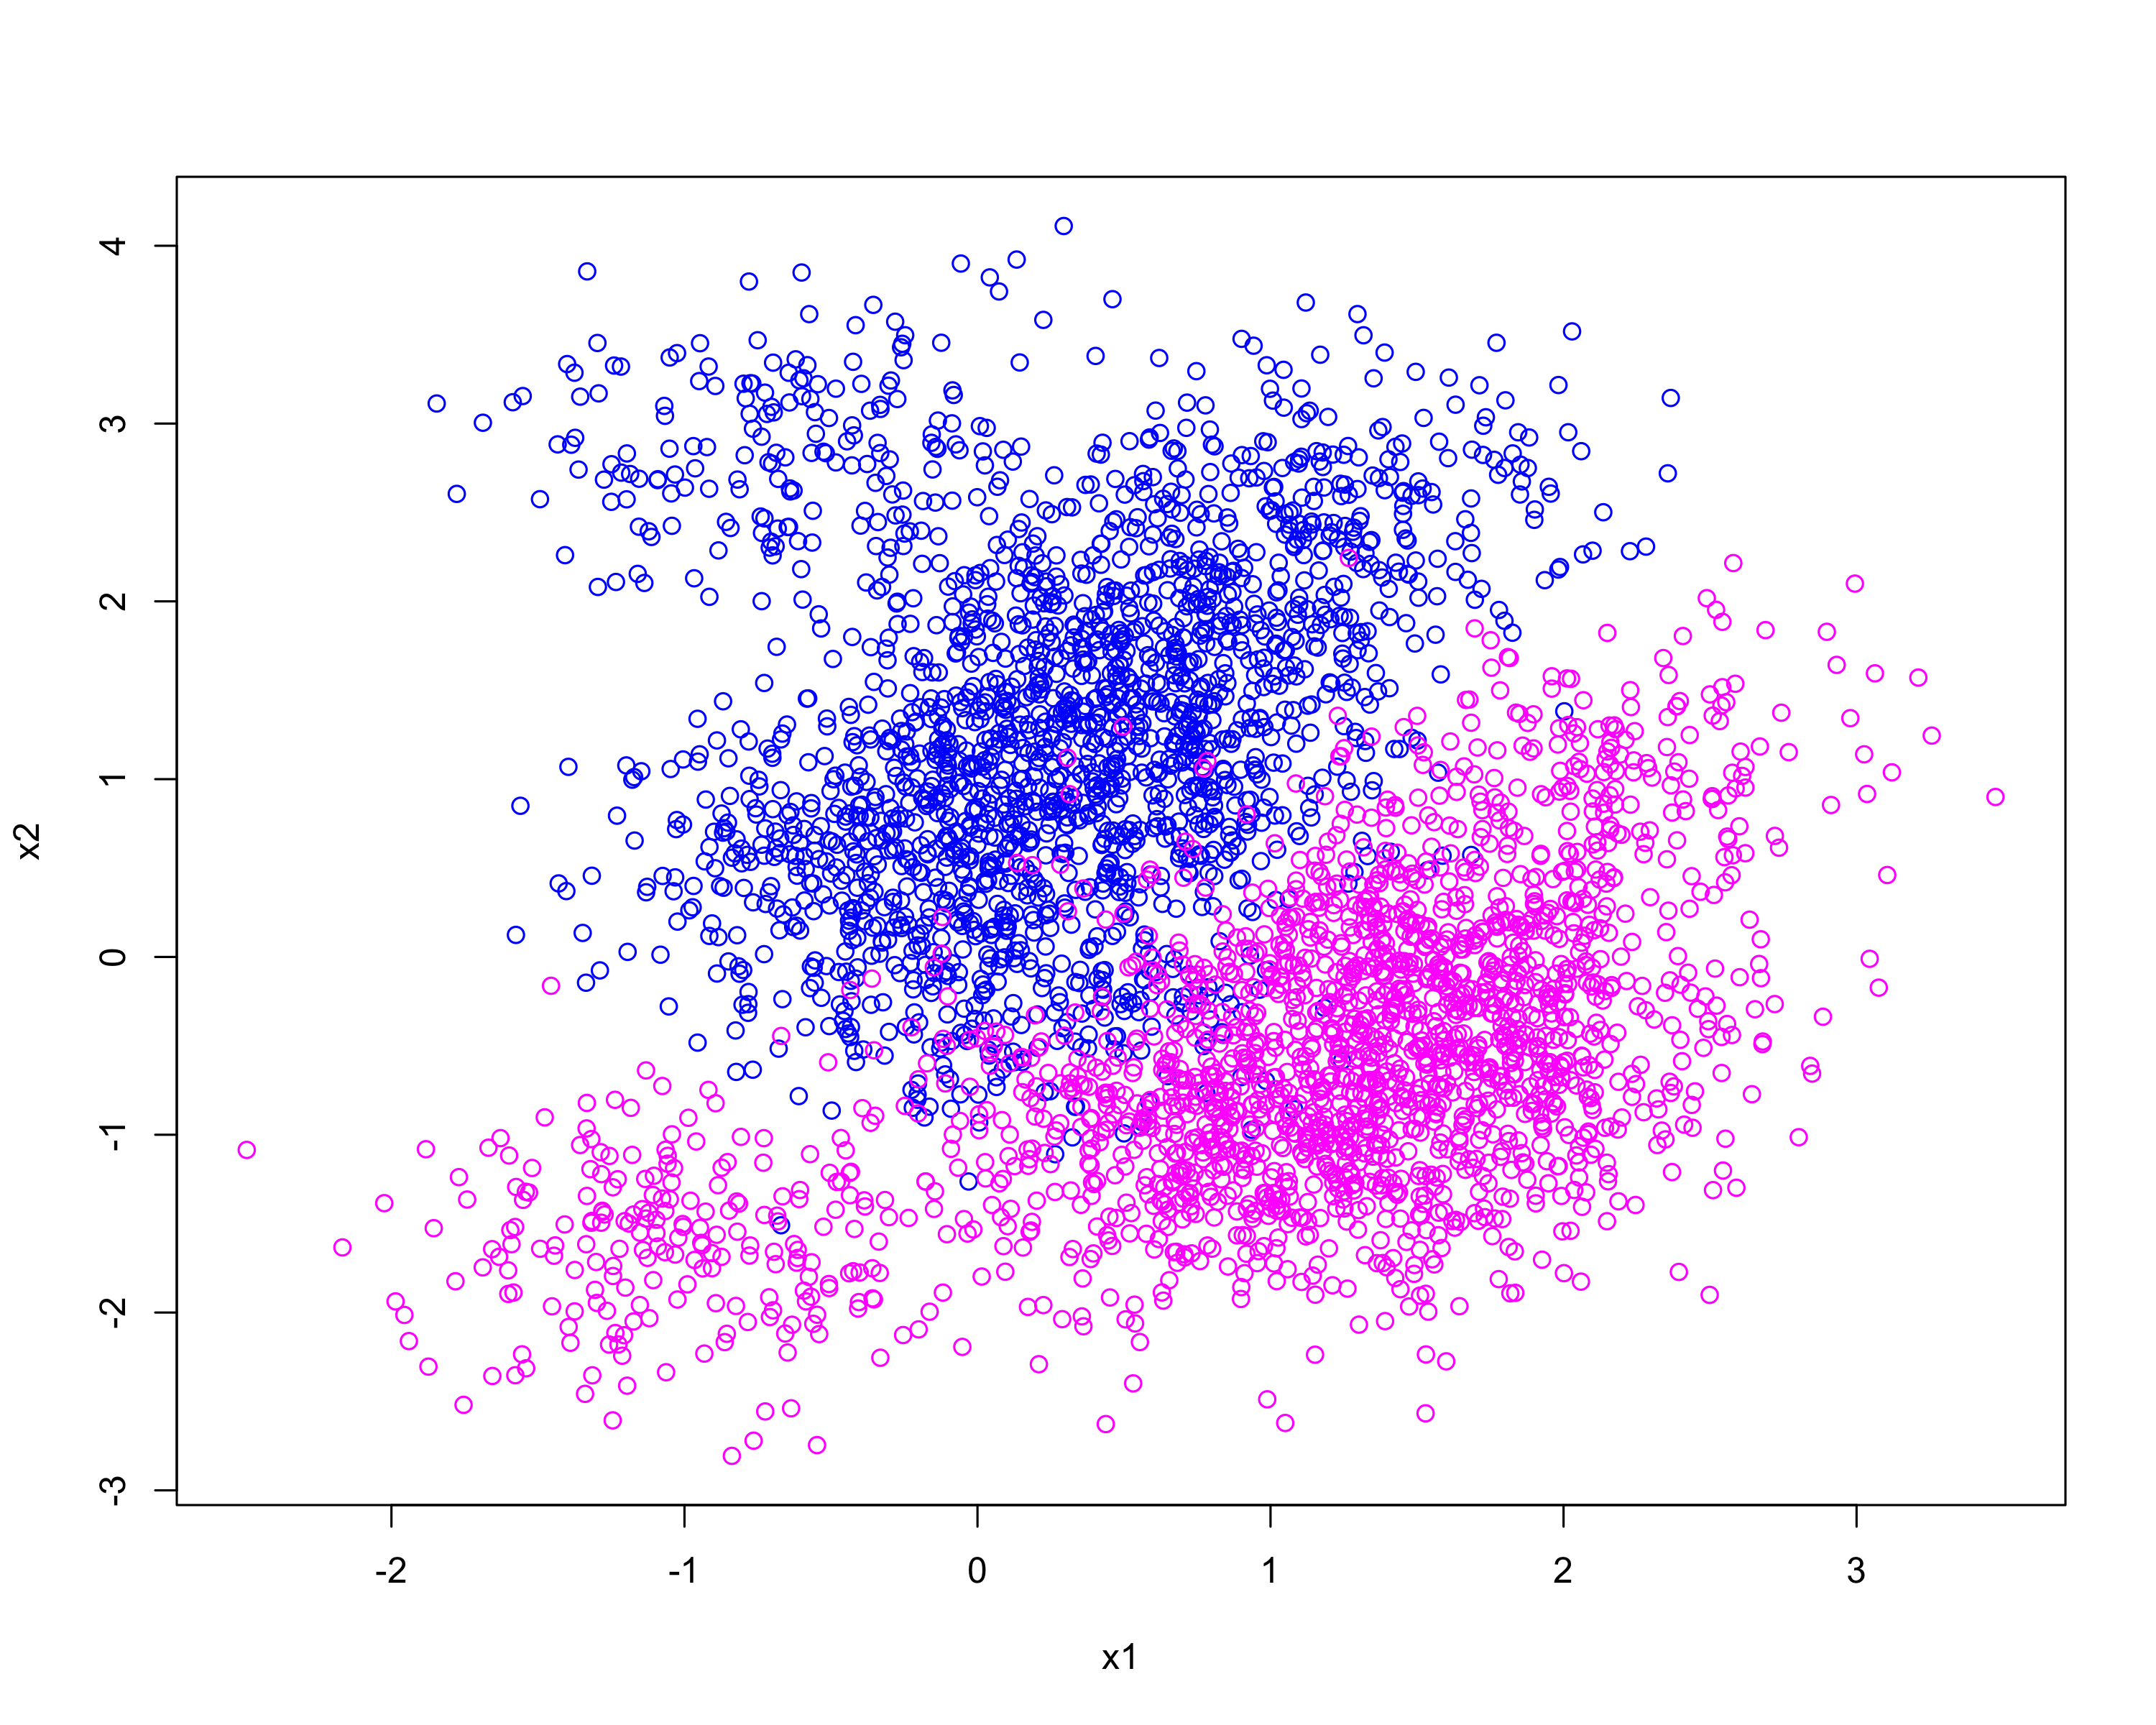

In [25]:
mask = fake_pop_data$y == -1

plot(fake_pop_data$x1[mask], fake_pop_data$x2[mask], col="blue", 
     xlim=c(min(fake_pop_data$x1),max(fake_pop_data$x1)), ylim = c(min(fake_pop_data$x2),max(fake_pop_data$x2)), 
     xlab="x1", ylab="x2")

points(fake_pop_data$x1[!mask], fake_pop_data$x2[!mask], col="magenta")

Ok, so the above is our simulated population -- we can use this population to "test" how well our classification goes on a smaller subset of data, i.e. our sample.

AGAIN: we will probably not have access to the actual distribution like we have here (which is just 2 gaussians -- the points simulated here).

Now, let's simulate a smaller sample, i.e. the training dataset.

Let's assume this sample dataset comes from this underlying population and is 400 points in total.

We'll use the sample function to randomly grab indicies from the population:

In [26]:
train_ind = sample.int(n = nrow(fake_pop_data), size = 400, replace = F)

Let's look at the random indicies, should range from 1-4000 (the length of our dataset):

In [27]:
train_ind

[1] 1649 1445 1053 2357  897 1355 2647 2693 1769 2319 3926 2577 2374 3505 2719
 [16] 1377  895 2330 3369 3750 1929 3939   60 1222 1110 2924 3409 3901 1934 1129
 [31] 3019 1657 1039 3974  485 1206 2279  458  527   61 3776 2116 2406 3998  560
 [46] 1337 1259 1234  554 3114 2387 1960 1559 3182 3061 2521  213 2021 1659 2615
 [61] 1870  974 1334 3113 1030  983  456 3213 3027   72 3315  702 2552 3466 2288
 [76] 3449  254 2049  137  672 2065 1379 2820 1055  936 1311 1570  887 1637 1460
 [91] 1144  310 1672  116  564 3955 1257 3893 3732 1516 1566 1792  561 2457 3688
[106]  480  159  365 2975  800  871 3375 3670 2678 3853 1458 2119 2392 2321  875
[121]  250  720 2619 3072 2424 1352 1009  423 2128 2754 3465  398 2814 3348  836
[136] 3945 1810 2110 2386   25   45  380 1207 1734 3554  284 2786  532 3561 2027
[151] 3789 3306 3961 3755 2776  320 2703 2840 2177 1002 1254 2202 2570 2091  525
[166] 3528 1124  835 2671 1758 1244  407  952 3154 1633 2230 1429 2026 3913 1590
[181]  217 2441 2791 3710 3794 2328 2499 3009 2947 1931 3304 1156  499  989 1809
[196] 2532  575 3443   50 2057 1550 2325 3584  855 1760 3543 3178 3271  792 3502
[211]  883 2260 3212 2124 3878 3215  678 1368 2136 2395 2139 1664 2572  274 1133
[226] 2079 2147 3573   54  430  106 3580 3729  997  677 2292 2010 1383  179  949
[241] 2760 2463  199 3548 1859  377 3733 3597  787  665 1718 2707 1164 1833  546
[256] 2443 2986  975 2933 3836 2028  147 2015  584 3129 3086 1801 1847 3950 2155
[271] 1273  506  156 1477 2757 3826  822 3376 1587  734  141 3712 2277 1271 2892
[286] 1231  326 3684 2316  935 3200 2089 1369  651  744 1656  607  671 2263  248
[301] 1985 1978 2843 2730 1182    7 2115 2846 1836 3924 3958 1917  795 3807   58
[316] 1107 1617 2851  994 1415 1673 3282 3201   40  315 3010 3648  212  513 1007
[331] 1255 3512  932  598 2969  332 2714 1593 2449 1709  529 2972 1065  241 2701
[346] 1835 3472 1042 1832 2431 3399 2041 3046 2623 1532   76  770  350 3674  572
[361] 2206  711  606 2613 1195 2496 2447 3186 2066 1016 1342 3313 2803 3682  374
[376] 2265 1640 1023  437 2989 1473 2656  133   80 2204 1955 2180  808 3423 3001
[391]  968 2007  530 3806 2159 2335 3299 1197 3508 3669

Now, we'll pull this data from our original fake population:

In [28]:
train_data = fake_pop_data[train_ind,]

In [29]:
head(train_data)

x1          x2         y 
1  0.38965743 -1.0773363 1 
2  1.80698776 -0.7169107 1 
3  1.20809564 -0.4012162 1 
4 -0.05827145 -0.7726721 -1
5  0.58869241  0.4911179 1 
6  0.18112672 -0.7940458 1

Let's take all of the fake population data *NOT* in our training data set and save it as a "test" dataset:

In [30]:
test_data = fake_pop_data[-train_ind, ]

Let's plot our training data!

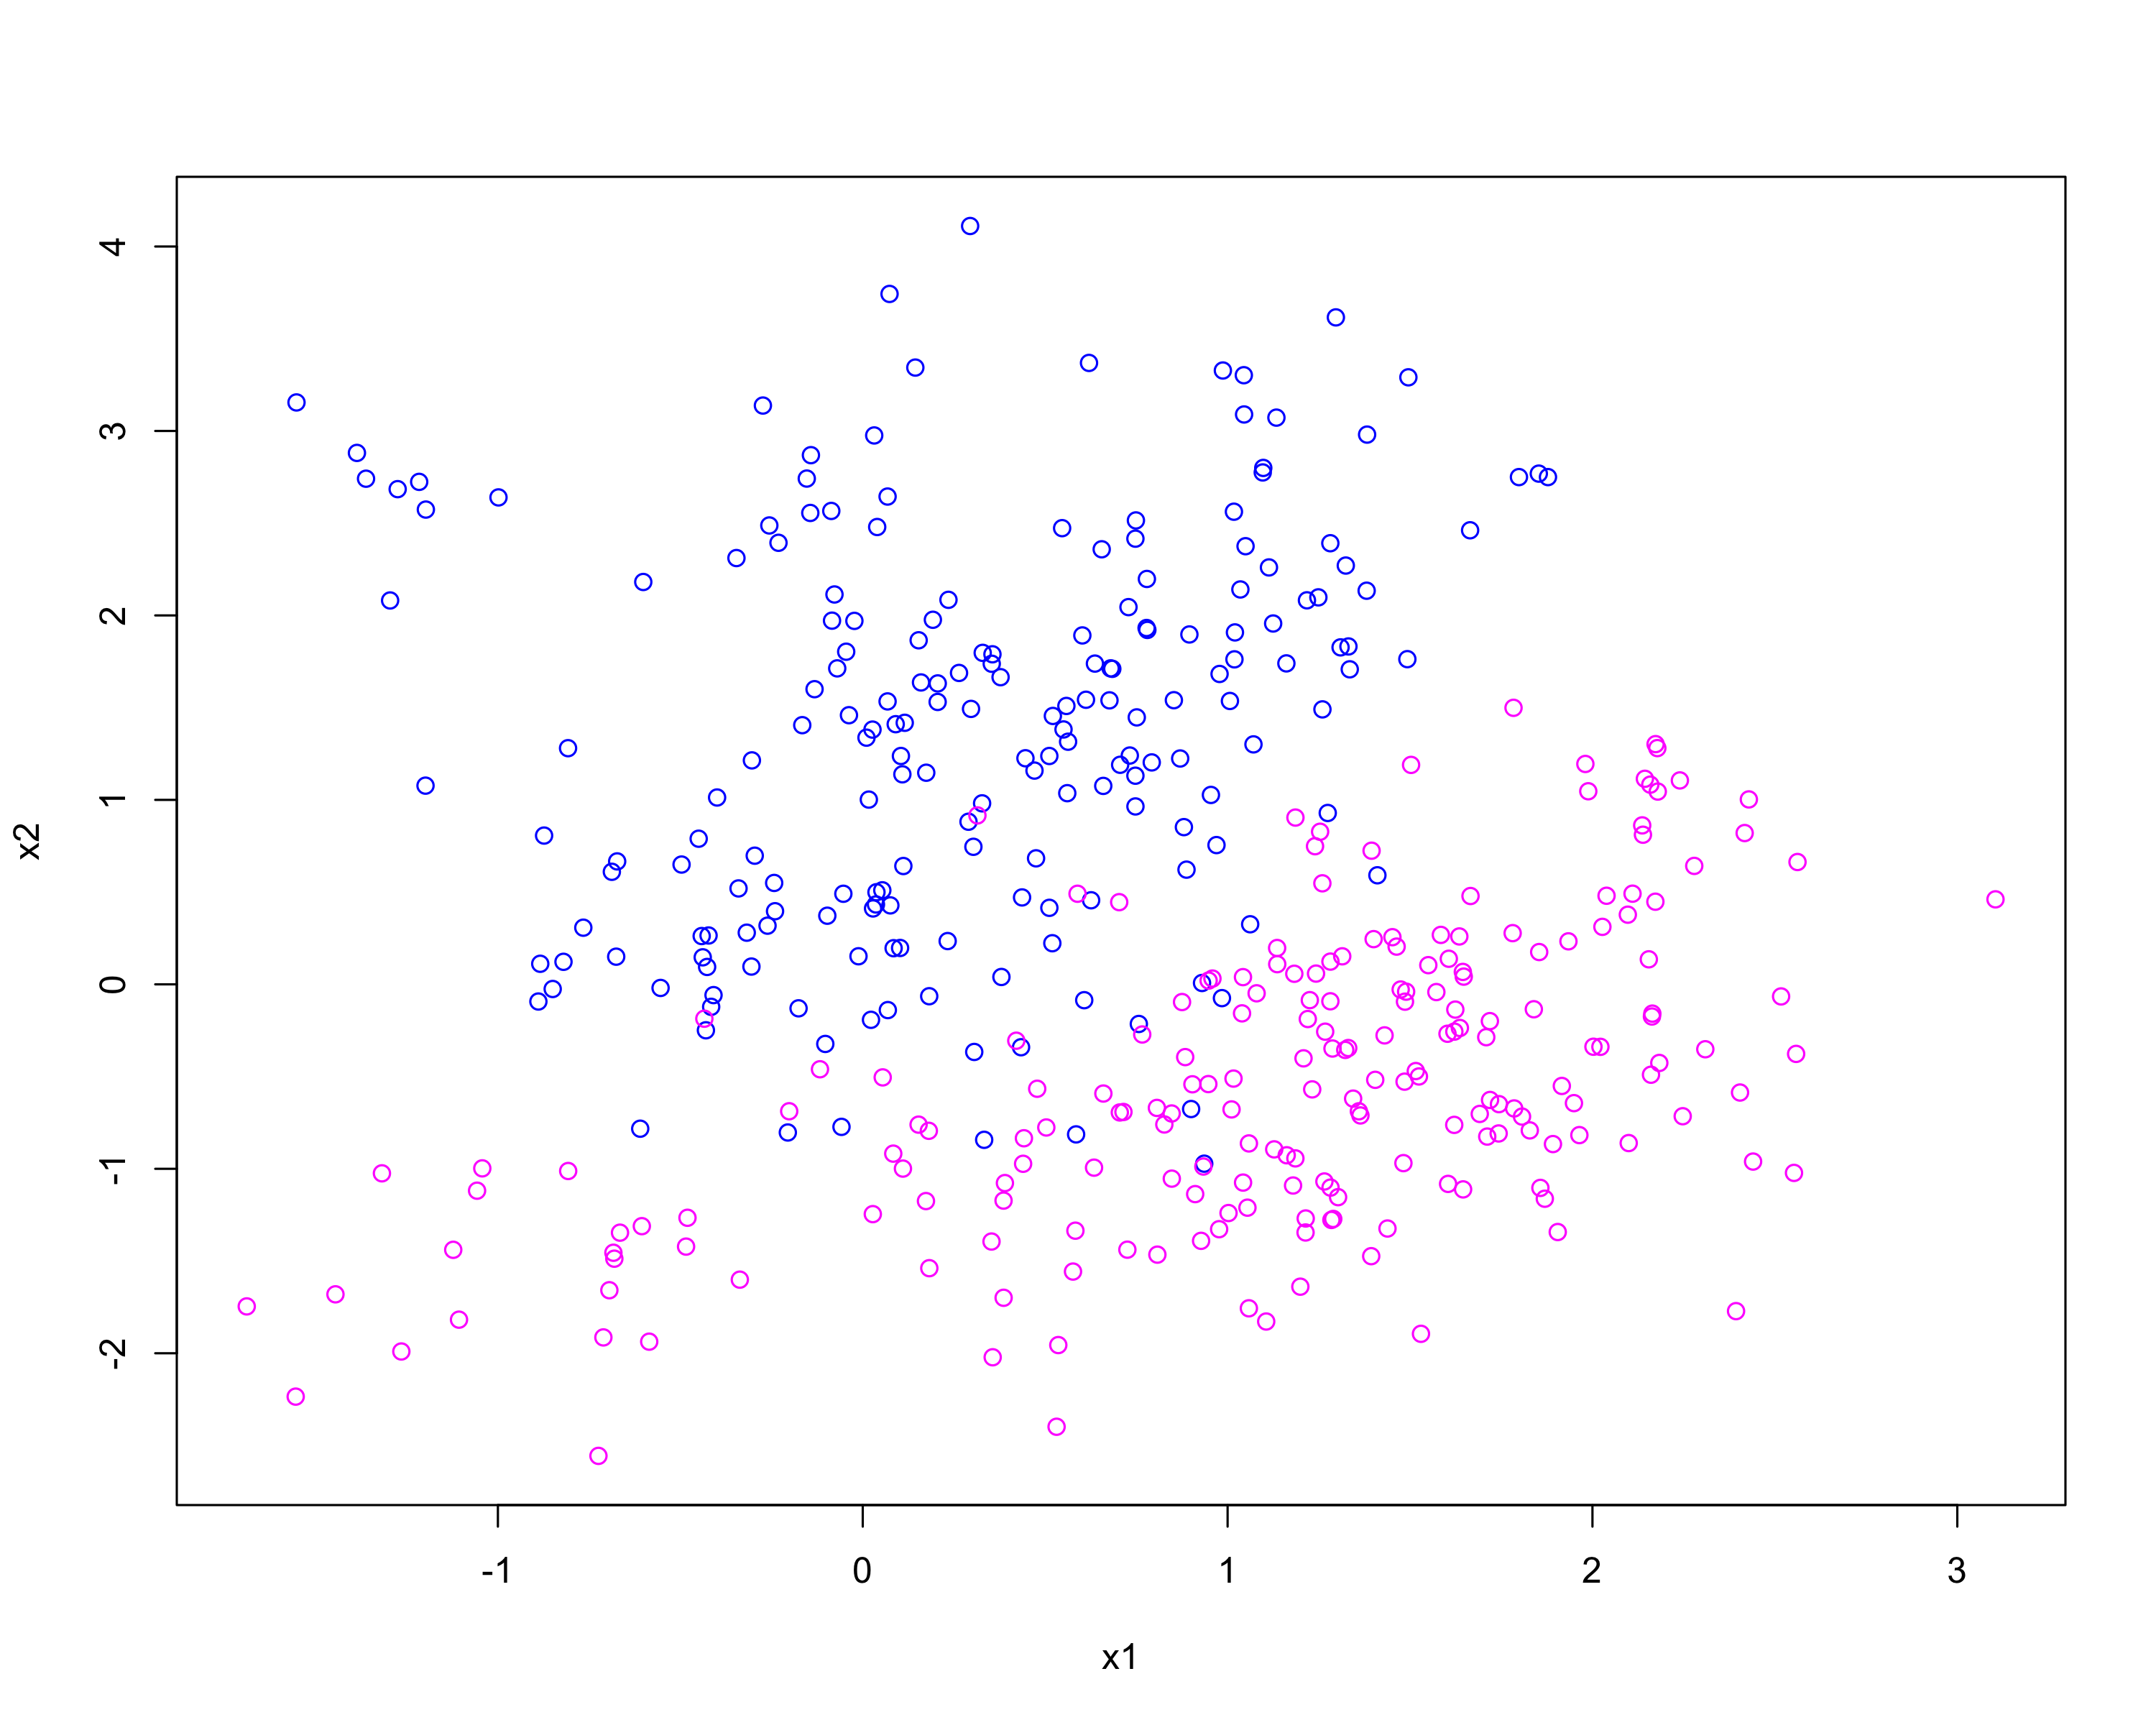

In [31]:
mask = train_data$y == -1

plot(train_data$x1[mask], train_data$x2[mask], col="blue", 
     xlim=c(min(train_data$x1),max(train_data$x1)), 
     ylim = c(min(train_data$x2),max(train_data$x2)), 
     xlab="x1", ylab="x2")

points(train_data$x1[!mask], train_data$x2[!mask], col="magenta")

As we did in the last lecture, let's classify this `train_data` with a KNN model, taking `k=5` like we did last time.

If we recall, we had to do some data reformatting:

In [32]:
# First, we turned our training data in to columns:
train.X = cbind(train_data$x1, train_data$x2)

Do our KNN classification on a grid:

In [33]:
# We then made a grid of new x1 & x2's
grid_size = 50 # number of new points we want to classify in x/y

# x1 & x2 ranges for fitting & plotting
x1min = -2
x1max = 4
x2min = -2
x2max = 4

x1_new = seq(x1min,x1max, length=grid_size)
x2_new = seq(x2min,x2max, length=grid_size)

new_grid.X = expand.grid(x1_new,x2_new)

Set our "k" in our KNN:

In [34]:
k = 5

Train our model & make a prediction:

In [35]:
knn_train_prediction = knn(train.X, new_grid.X, train_data$y, k=k, prob=T)

In [36]:
knn_train_prediction

[1] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
  [25] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
  [49] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
  [73] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
  [97] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [121] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [145] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [169] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [193] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [217] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [241] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [265] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [289] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [313] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [337] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [361] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [385] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [409] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [433] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [457] 1  1  1  1  1  1  1  -1 -1 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [481] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [505] 1  1  1  1  1  1  1  1  -1 -1 -1 1  1  1  1  1  1  1  1  1  1  1  1  1 
 [529] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [553] 1  1  1  1  1  1  1  1  1  -1 -1 -1 -1 1  1  1  1  1  1  1  1  1  1  1 
 [577] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [601] 1  1  1  1  1  1  1  1  -1 -1 -1 -1 1  -1 -1 1  1  1  1  1  1  1  1  1 
 [625] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [649] 1  1  1  1  1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1  1  -1 -1 -1 1  1  1 
 [673] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [697] 1  1  1  1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 [721] -1 -1 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [745] 1  1  1  1  1  1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 [769] -1 -1 -1 -1 -1 -1 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [793] 1  1  1  1  1  1  1  1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 [817] -1 -1 -1 -1 -1 -1 -1 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [841] 1  1  1  1  1  1  1  1  1  1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 [865] -1 -1 -1 -1 -1 -1 -1 -1 -1 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 [889] 1  1  1  1  1  1  1  1  1  1  1  1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 [913] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1  1  1  1  1  1  1  1  1  1  1  1  1 
 [937] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 [961] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1  1  1  1  1  1  1  1  1  1 
 [985] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1 -1 -1 -1 -1 -1 -1 -1
[1009] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1  1  1  1  1  1 
[1033] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1 -1 -1 -1 -1 -1
[1057] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1  1  1  1 
[1081] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1 -1 -1 -1
[1105] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1  1 
[1129] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  -1 -1
[1153] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 
[1177] 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
[1201] -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -

Grab the probability from this model.

Recall:  the probability of belonging to a group 0.5 as the boundary - prob=1 means positive group, prob=0 means negative group:

In [37]:
prob = attr(knn_train_prediction, "prob")
prob

[1] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
  [19] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
  [37] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
  [55] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
  [73] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
  [91] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [109] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [127] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [145] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [163] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [181] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [199] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [217] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [235] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [253] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [271] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [289] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [307] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [325] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [343] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [361] 1.0 1.0 1.0 0.8 0.8 1.0 0.8 1.0 1.0 1.0 1.0 1.0 1.0 0.8 1.0 1.0 1.0 1.0
 [379] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [397] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 0.8 0.8 0.8 0.6
 [415] 0.6 0.6 0.8 1.0 0.8 0.8 1.0 0.8 0.8 0.8 0.8 0.8 1.0 1.0 1.0 1.0 1.0 1.0
 [433] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [451] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 0.8 0.8 0.8 0.6 0.6 0.6 0.6 0.6 0.8
 [469] 0.8 0.8 0.6 0.8 0.8 0.8 0.8 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [487] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [505] 1.0 1.0 0.8 0.8 0.8 0.8 0.8 0.6 0.6 0.6 0.6 0.6 0.6 0.8 0.8 0.8 0.6 0.8
 [523] 0.8 0.8 0.8 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [541] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 0.8 0.8 0.8 0.8
 [559] 0.8 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.8 0.8 0.8 0.8 0.8 1.0 1.0 0.8 0.8 0.8
 [577] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [595] 1.0 1.0 1.0 1.0 1.0 1.0 0.8 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 [613] 0.6 0.6 0.6 0.6 0.6 0.6 0.8 0.6 0.6 0.8 1.0 0.8 0.8 1.0 1.0 1.0 1.0 1.0
 [631] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [649] 1.0 1.0 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.8 1.0 0.8 0.8 0.8 0.8 0.6 0.6 0.6
 [667] 0.6 0.6 0.6 0.6 0.6 0.8 0.8 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [685] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.6 0.6
 [703] 0.6 0.8 0.8 0.8 1.0 1.0 1.0 1.0 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 [721] 0.6 0.6 0.6 0.8 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [739] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 0.8 0.8 0.8 1.0 1.0
 [757] 1.0 1.0 1.0 1.0 1.0 0.8 0.8 0.8 0.8 1.0 1.0 1.0 0.8 0.8 0.8 0.6 0.6 0.6
 [775] 0.6 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [793] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 0.8 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [811] 1.0 1.0 0.8 0.8 1.0 1.0 1.0 1.0 1.0 0.8 0.8 0.8 0.6 0.6 0.6 0.8 1.0 1.0
 [829] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [847] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [865] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.6 0.6 0.6 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [883] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 [901] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.

We'll use the plotting function from last lecture to do the plotting for us:

In [38]:
source('https://raw.githubusercontent.com/jnaiman/is507_fall2020/master/week13/classification_plotting_function.R')

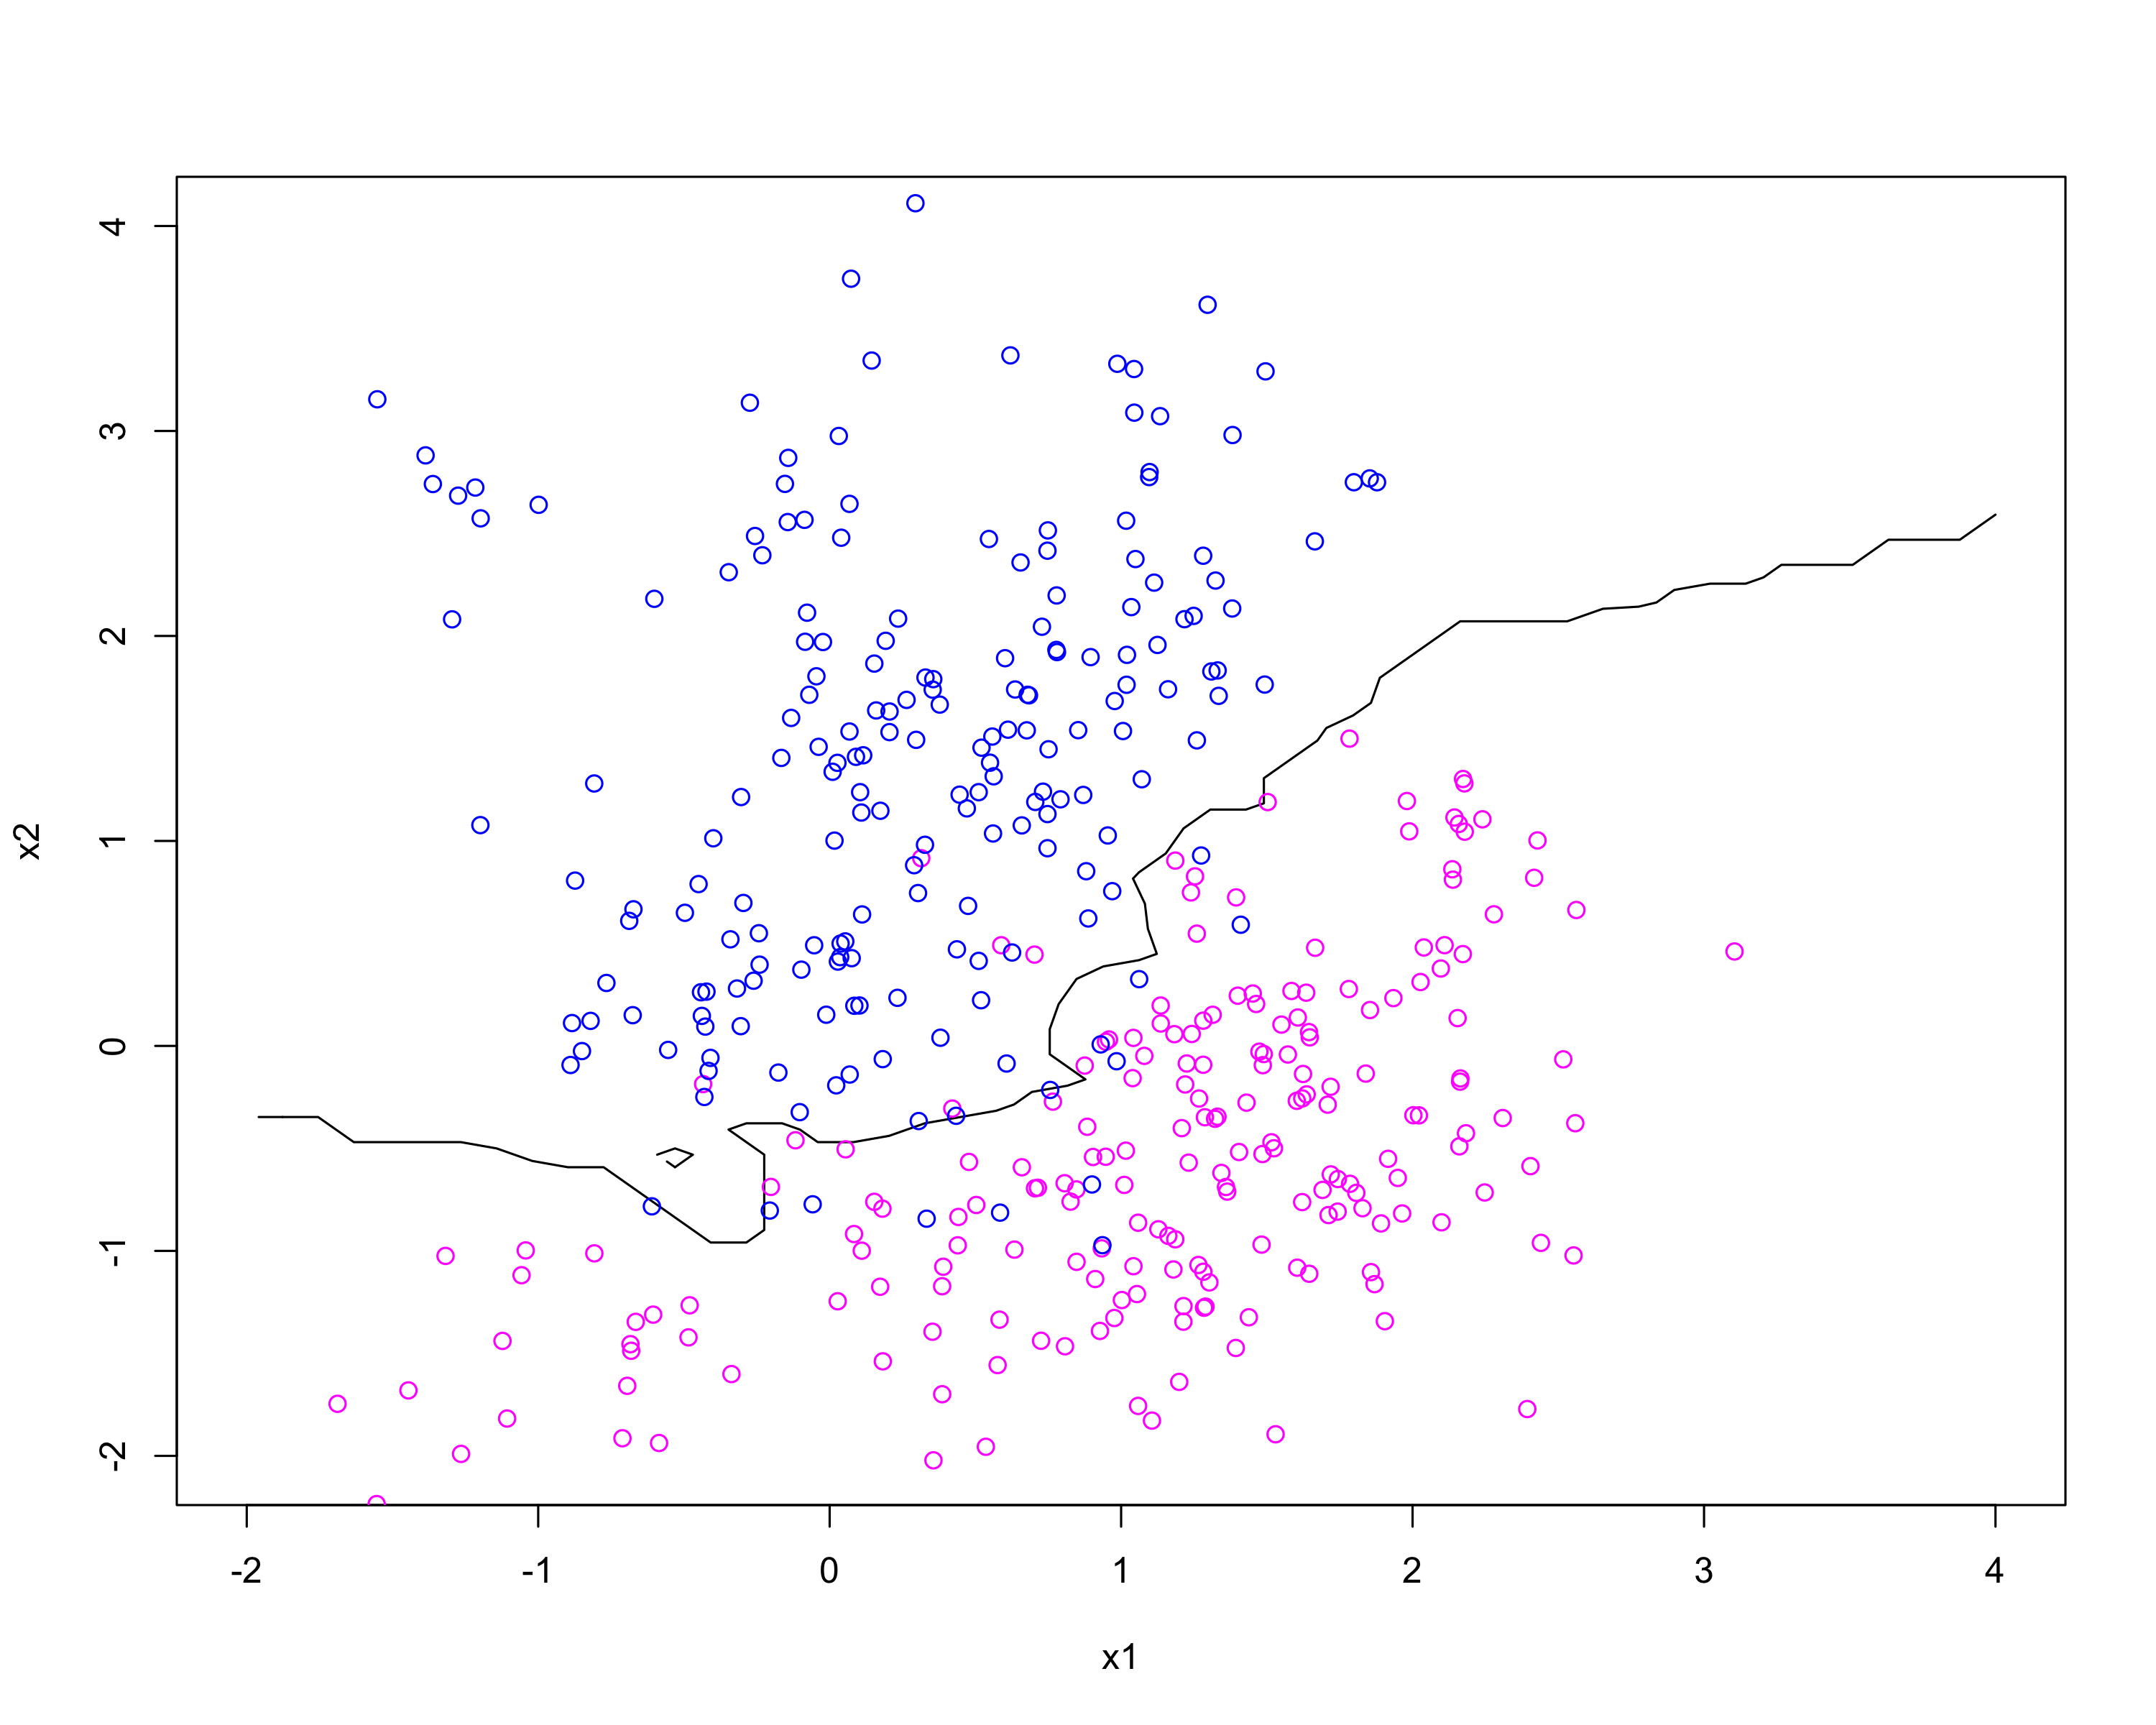

In [39]:
# specify the "cut off probability", usually 0.5
prob_cut_off = 0.5

plot2dProbKNN(knn_train_prediction, train_data, grid_size, prob_cut_off, x1min,x1max, x2min,x2max, prob)

# This is where we got to last lecture!

## 2. Calculating train and test errors with access to the underlying population

Here, because we have the underlying distribution - test_data, we can use a useful function to calculate *both* the test and the training error.

Recall: 
 * Training error is $\frac{1}{n} \times {\rm{SUM}} ( {\rm{Indicator}}(y_i != \hat{y}_i) )$ for our sample
 * Test error is Average( Indicator($y_0$ != $\hat{y}_0$) ) for a new observation

Note: we can calculate the training error by hand as well:

In [40]:
knn_train_prediction_training = knn(train=train.X, 
                                    test=train.X, cl=train_data$y, k=k)

length(knn_train_prediction_training[knn_train_prediction_training != train_data$y])/length(train_data$y)

[1] 0.0475

We'll use the STOR390 functions to calculate this for us:

In [41]:
errs = get_knn_error_rates(train_data, test_data, k)

In [42]:
errs

$tr
[1] 0.0475

$tst
[1] 0.05083333

So here "tr" is the training error (sample) and "tst" is the test error (new observation from population *NOT* in the training data).



Also try with different k's **DO THIS BY HAND ON YOUR OWN**

Let's look at a few different k's all at once.  We played a bit with this last week, but let's add the errors in as well to our plot:

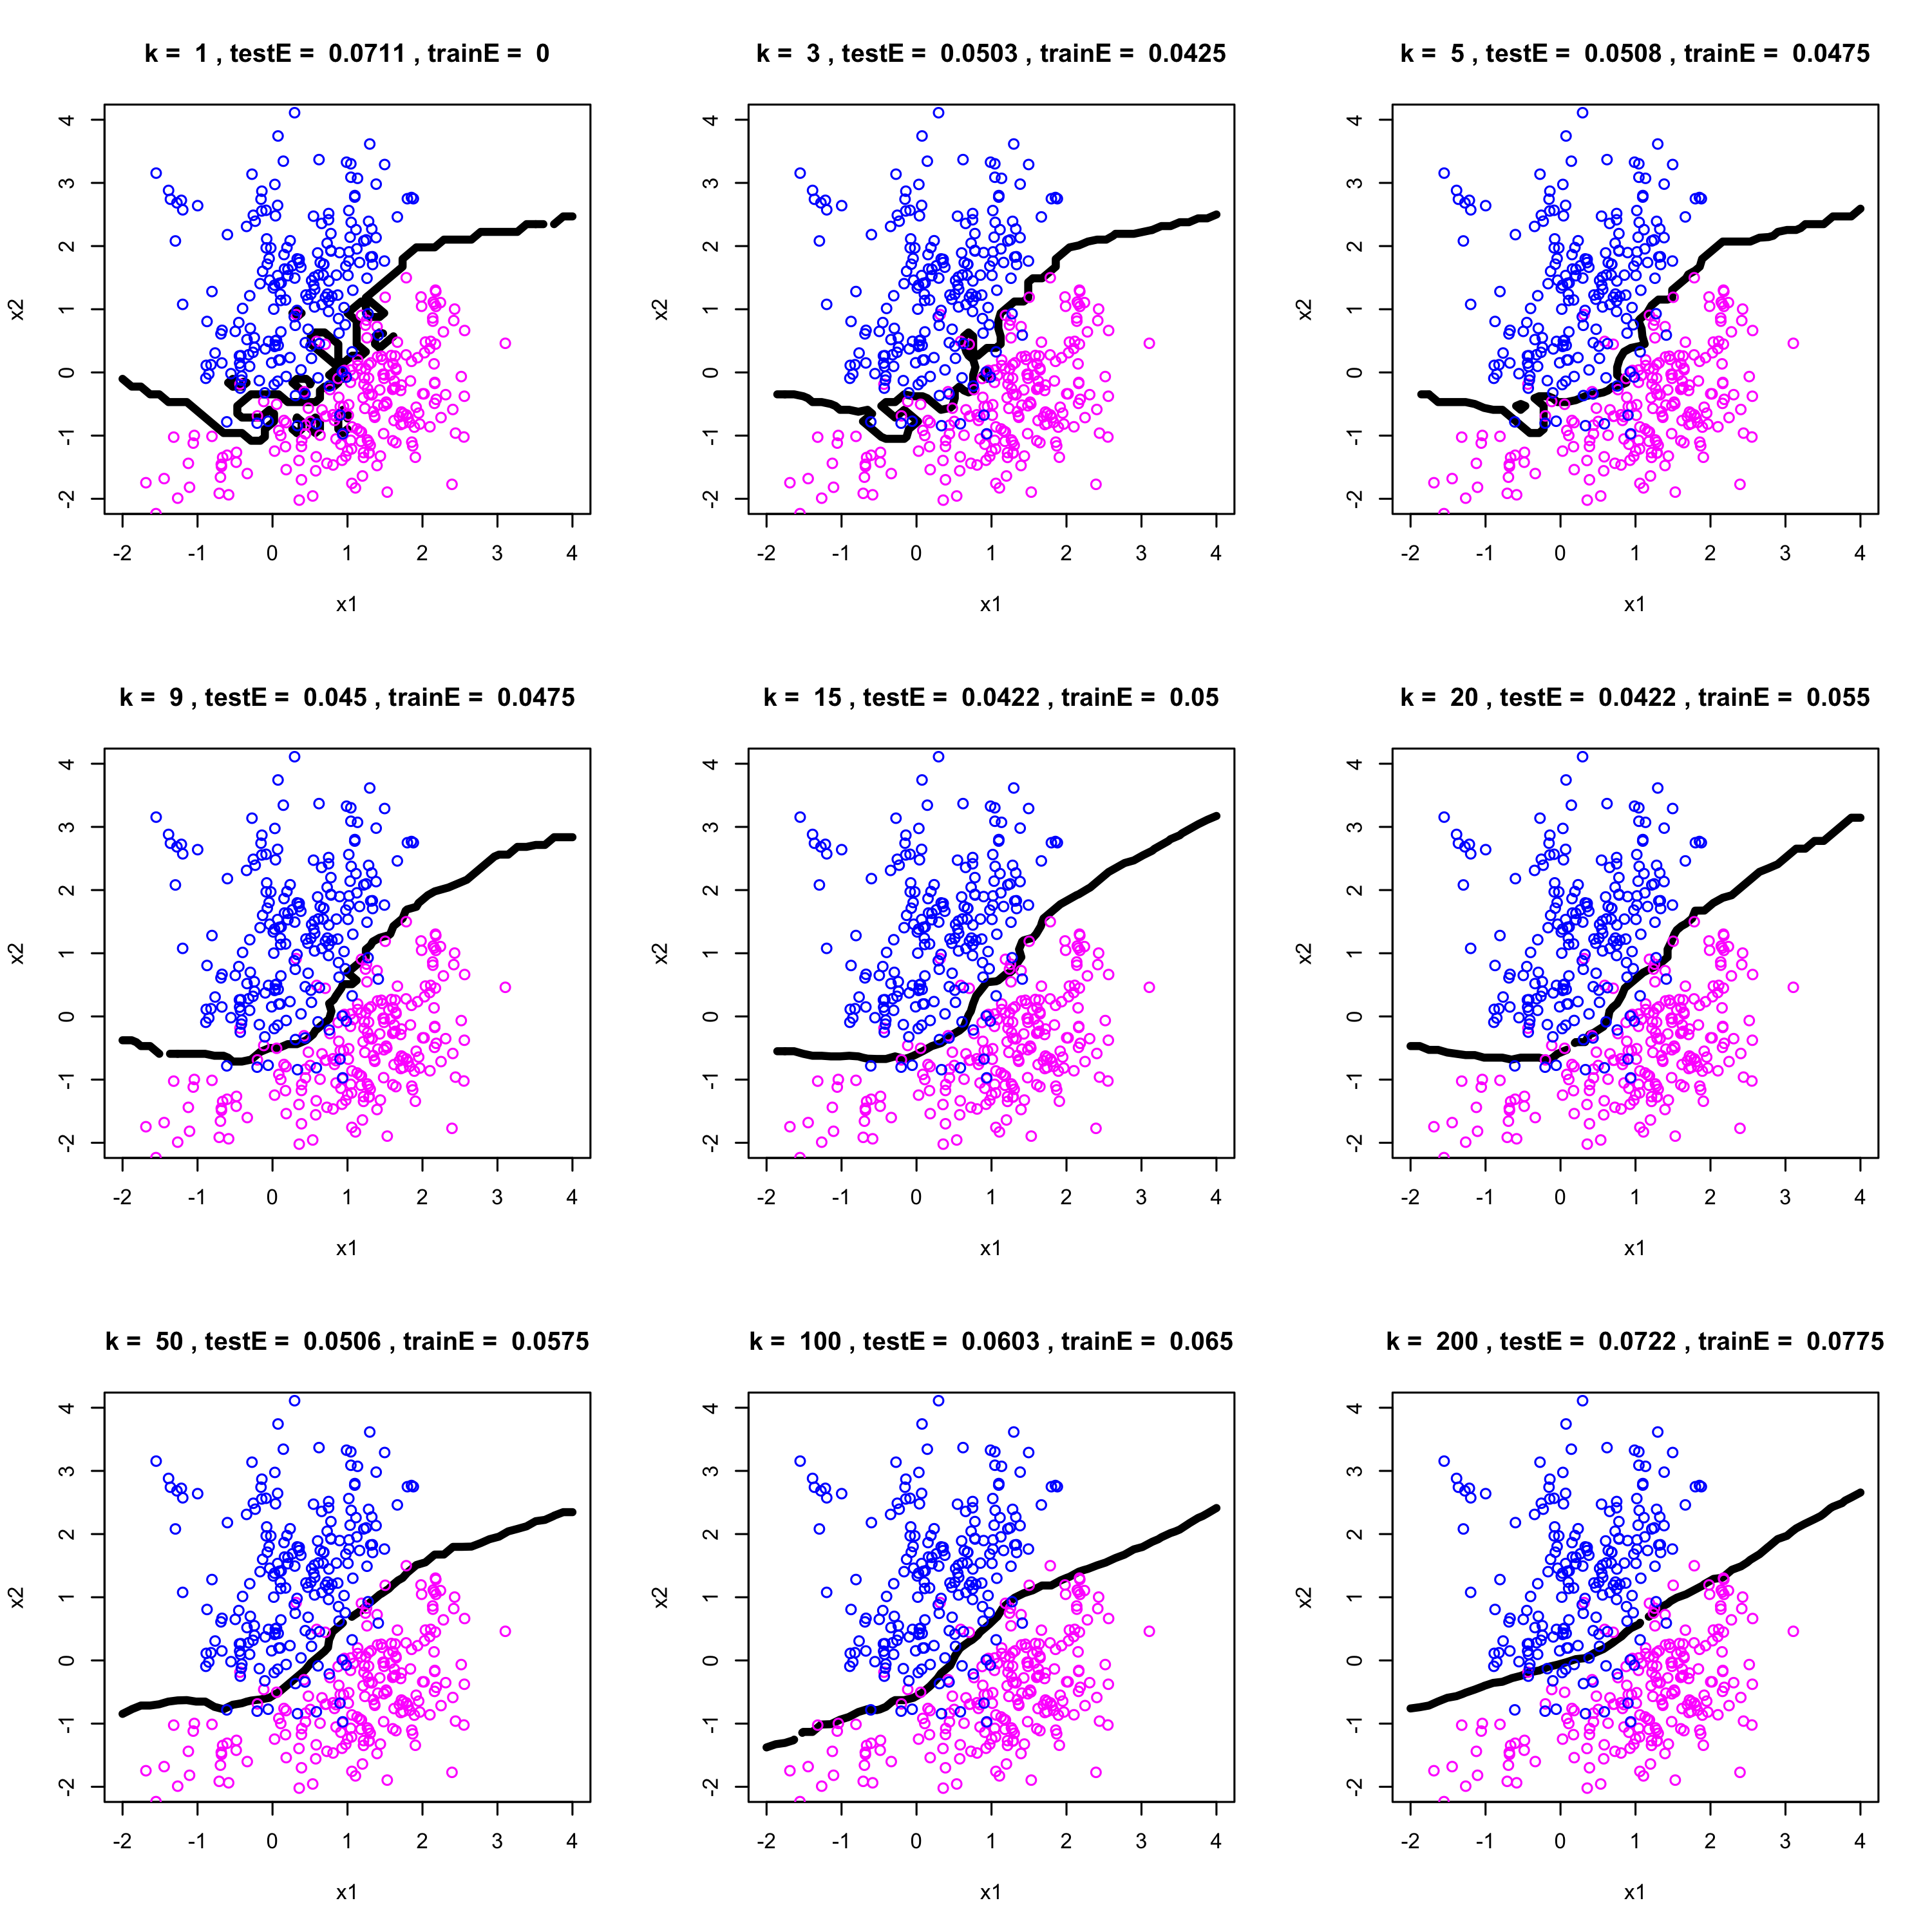

In [43]:
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow = c(3,3))

k_values = c(1, 3, 5, 9, 15, 20, 50, 100, 200)


for (i in 1:length(k_values)){
  # let's make prediction!
  knn_train_prediction = knn(train.X, new_grid.X, train_data$y, k=k_values[i], prob=T)
    
  # get errors:
  errs = get_knn_error_rates(train_data, test_data, k_values[i])

  # grab classification prob and transform it for
  #  plotting with contour plot
  prob = attr(knn_train_prediction,"prob")
    
  # make title labels
  #titleLab = paste("k = ", toString(k_values[i]))
  titleLab = paste("k = ", toString(k_values[i]), ", testE = ", toString(round(errs$tst,4)), 
                   ", trainE = ", toString(round(errs$tr,4)))
  # plot!
  plot2dProbKNN(knn_train_prediction, train_data, grid_size, 
                prob_cut_off, x1min,x1max, x2min,x2max, prob, 
                title=titleLab, lwd=4)
}

We can see that the test & training errors change with different k values. 

Training error tends to increase with increasing complexity (here, lower k) - model getting further from fitting our sample dataset.

Testing error tends to decrease before increasing again - model gets closer to test data, and diverges again.

Let's plot both of these errors as a function of k:

NOTE: this can take a while to first do the calculation...

In [44]:
k_values = seq(from=1, to=400, by=4) # only go up to 200
num_k = length(k_values)
tr = c() # start with empty training & test error arrays
tst = c()
# now lets loop
for( i in 1:num_k ){
  errs = get_knn_error_rates(train_data, test_data, k_values[i])
  tr = append(tr, errs$tr) # fill training array
  tst = append(tst, errs$tst) # fill test array
}

Plot!

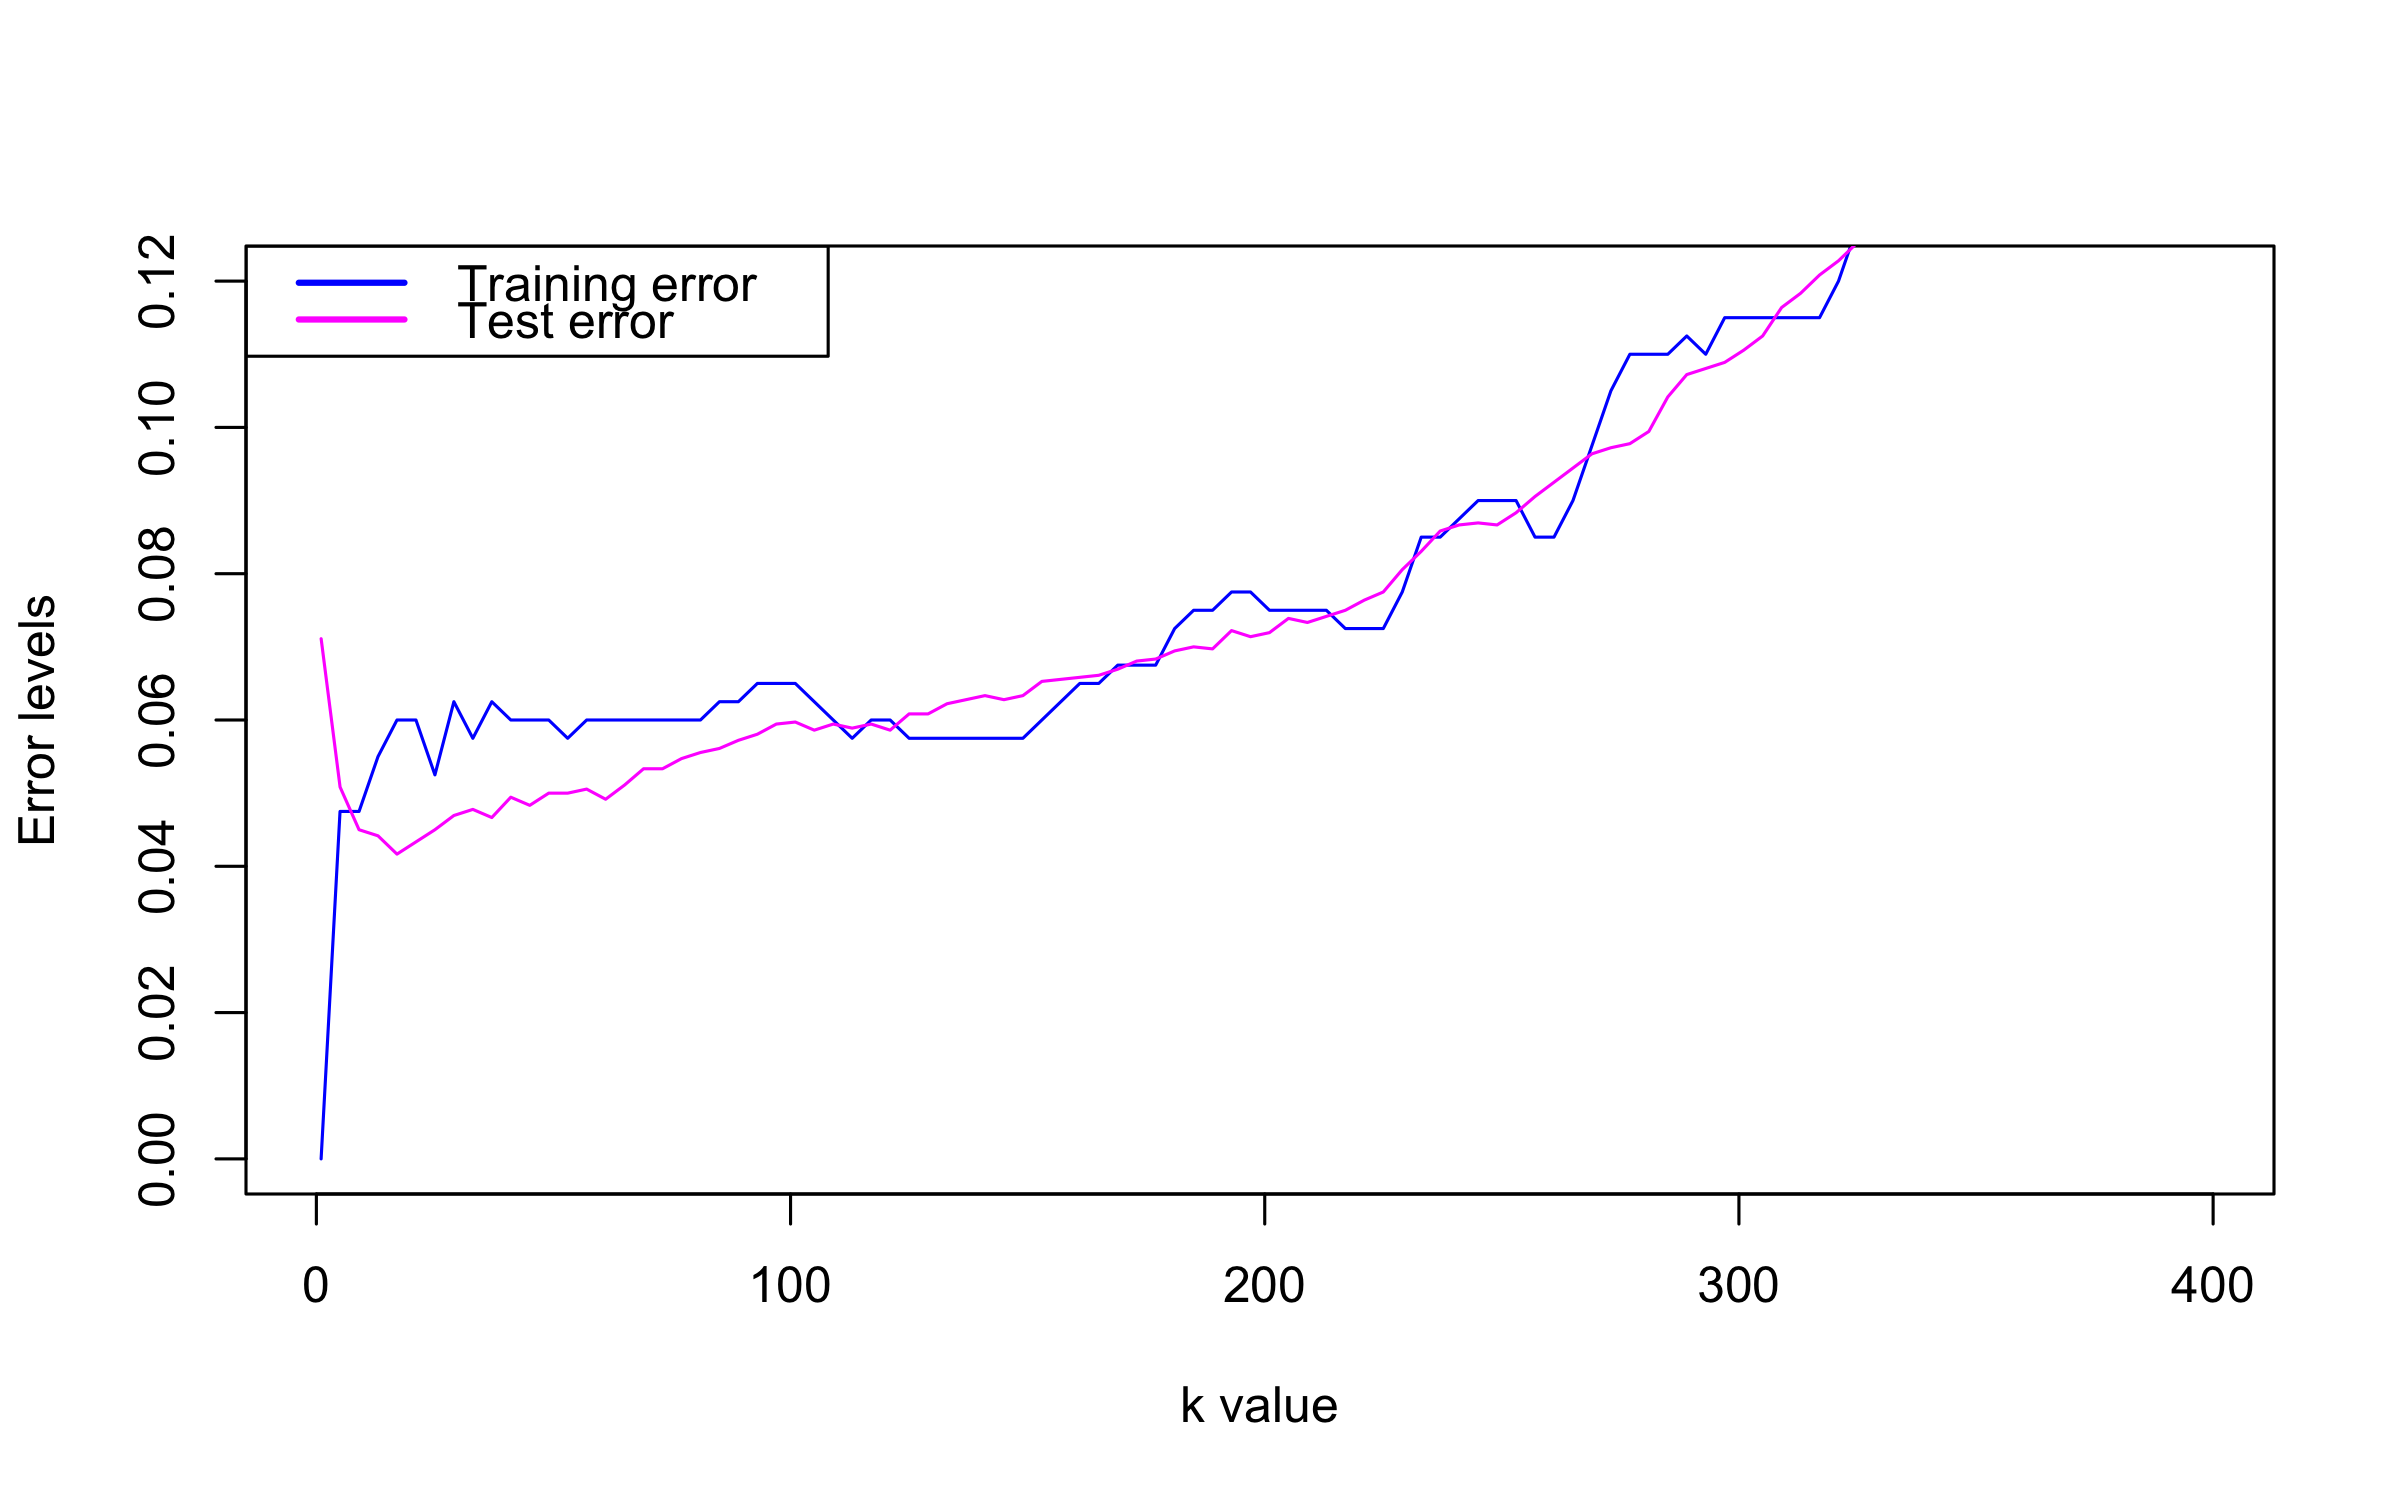

In [45]:
options(repr.plot.width=8, repr.plot.height=5)

plot(k_values, tr, xlab='k value', ylab='Error levels', type='l', col='blue', ylim=c(0.0,0.12))
lines(k_values, tst, col="magenta")
legend("topleft",c("Training error","Test error"),col=c("blue","magenta"), lwd=2)

NOTE: that the training error (sample) tends to increase with increasing complexity (increasing k) -- i.e. as our line fits less the data by being wiggly this increases.

Test error has a characteristic U shape by looking at these 2 lines it seems that k ~ 5-10 minimizes both test and training errors.

So, in this example, we had the background model and used it to generate the TEST data set, but usually, we won't be using simulated data, so then what?  Who do we get the Test error rate and not just the training error rate so that we can get the full error rate?

We can look at a few different methods, but first we'll start with the CROSS-VALIDATION set of methods.

## 3. TO SLIDES TO TALK ABOUT CROSS VALIDATION (CV)

## 4. k-fold Cross Validation

Now, let's pretend we don't know the underlying distribution i.e. all we have is "train_data" from above, and not "test_data".

What we are going to do is split the train_data into 2 groups a "fake" training set and a "fake" testing set i.e. the "validation set".

Let's select how many times we want to break our data into these groups:

In [46]:
k_folds_k = 5 #  note, both KNN and k-folds use a "k", hence the silly naming

Process for each k_folds_k is as follows:
 1. split data into training set & validation set randomly
   * (k\_folds\_k-1)/(k\_folds\_k) % of the data is in training, 
   * remaining 1/k\_folks\_k is in validation (fake "test") dataset
 2. Fit model on train data
 3. Compute train & test error using train and validation data
 4. Use the test error as a proxy for our validation error: 
   * i.e. CV = Test error is Average( Indicator($y_0$ != $\hat{y}_0$) )

NOTE: we're only going to store the test error here because we are using CV to test how well our model fits the *underlying population*. We are in essense *model picking*.

In the end, we'll have our "best set of parameters" and we can go back and calculate the full MSE for our fit which will tell us both how well we fit the data but also (about) how well we are fitting the underlying population.


Do 1-3 for each "k" of the KNN process we are interested in this gives use a k by k\_folds\_k matrix of errors we'll use this to calculate the error on our model.

Ok, enough chit chat, lets do it!

In [47]:
k_values = seq(from=1, to=100, by=2) # lets stay small to start with
num_k = length(k_values) # keep track of how many k-values we have in our array
num_k

[1] 50

Let's store our errors for each k-KNN and k-folds combination in a matrix:

In [48]:
error_matrix = matrix(0, nrow=num_k, ncol=k_folds_k)

It starts off as an empty matrix full of zeros:

In [49]:
head(error_matrix)

[,1] [,2] [,3] [,4] [,5]
[1,] 0    0    0    0    0   
[2,] 0    0    0    0    0   
[3,] 0    0    0    0    0   
[4,] 0    0    0    0    0   
[5,] 0    0    0    0    0   
[6,] 0    0    0    0    0

Ok, so that is going to be a little hard to keep track of, lets do something fancy using "tibble", which is just a fancy labeled table.

We'll "pipe" our matrix into a tibble using the piping symbol: `%>%`

We'll also add a column at the end of our matrix to keep track of the k-KNN:

In [50]:
error_matrix = matrix(0, nrow=num_k, ncol=k_folds_k) %>% as_tibble() %>% add_column(k=k_values)

In [51]:
head(error_matrix)

V1 V2 V3 V4 V5 k 
1 0  0  0  0  0   1
2 0  0  0  0  0   3
3 0  0  0  0  0   5
4 0  0  0  0  0   7
5 0  0  0  0  0   9
6 0  0  0  0  0  11

Almost there!  We'll also name the rest of our matrix columns by replacing the "V" with "fold":

In [52]:
colnames(error_matrix) = str_replace(colnames(error_matrix), 'V', 'fold')

In [53]:
head(error_matrix)

fold1 fold2 fold3 fold4 fold5 k 
1 0     0     0     0     0      1
2 0     0     0     0     0      3
3 0     0     0     0     0      5
4 0     0     0     0     0      7
5 0     0     0     0     0      9
6 0     0     0     0     0     11

Now we have labels of rows (each is a k value up to 100) under the "k" column, and the "fold" we are using is along the column the entries.

We'll store our total MSE from both tr & tst in each entry of our matrix.

While we want to do select samples for test & train randomly in theory, in practice here we are going to set a seed so we all get the same thing.

We'll now perform the steps listed at the beginning of this section:

 1. split data into training set & validation set randomly
   * (k\_folds\_k-1)/(k\_folds\_k) % of the data is in training, 
   * remaining 1/k\_folks\_k is in validation (fake "test") dataset
 2. Fit model on train data
 3. Compute train & test error using train and validation data
 4. Use the test error as a proxy for our validation error: 
   * i.e. CV = Test error is Average( Indicator($y_0$ != $\hat{y}_0$) )
   
We'll do this for each combination of k-KNN and k-fold so we'll have two nested for-loops:


In [54]:
set.seed(31244) # use different one

# ok, lets loop and fill our matrix!
n = nrow(train_data) # total number of original training points
for(m in 1:k_folds_k){
  # calculate the number of data points that go into the new training set
  n_cv_tr = floor(n * (k_folds_k-1)/k_folds_k ) 
  
  # now, lets grab the indices of our new training dataset
  # note that we want unique indices so we sample w/o replacement
  # again, our "sample" function is just pulling random indicies
  #  so we can grab random points from our sample
  cv_tr_indices = sample(x=1:n, size=n_cv_tr, replace=FALSE)
  
  # pull from our original training data set our k-folds training and test sets
  cv_tr = train_data[cv_tr_indices, ] # training indicies
  cv_tst = train_data[-cv_tr_indices, ] # - sign means NOT training indicies
  
  # now that we have our fake training & test sets, 
  #  again loop over each KNN k and calculate 
  #  test & training errors
  for(i in 1:num_k){ # loop for each KNN-k!
    # compute the test error on the validation set
    errs <- get_knn_error_rates(cv_tr, cv_tst, k_values[i])
    # store values in the data frame
    error_matrix[i, paste0('fold',m)] = errs[['tst']]####+errs[['tr']]
    # remember, only using tst error as a proxy for our CV error (see ISL 5.1.5) for now
  }
  
}

This then fills our error matrix:

In [55]:
head(error_matrix)

fold1  fold2  fold3  fold4  fold5  k 
1 0.0500 0.0875 0.1375 0.0875 0.0625  1
2 0.0500 0.0750 0.0500 0.0875 0.0250  3
3 0.0625 0.0750 0.0500 0.0625 0.0250  5
4 0.0875 0.0625 0.0500 0.0500 0.0250  7
5 0.0875 0.0750 0.0500 0.0375 0.0250  9
6 0.0750 0.0750 0.0500 0.0500 0.0250 11

Now, lets plot our CV results the first fold:

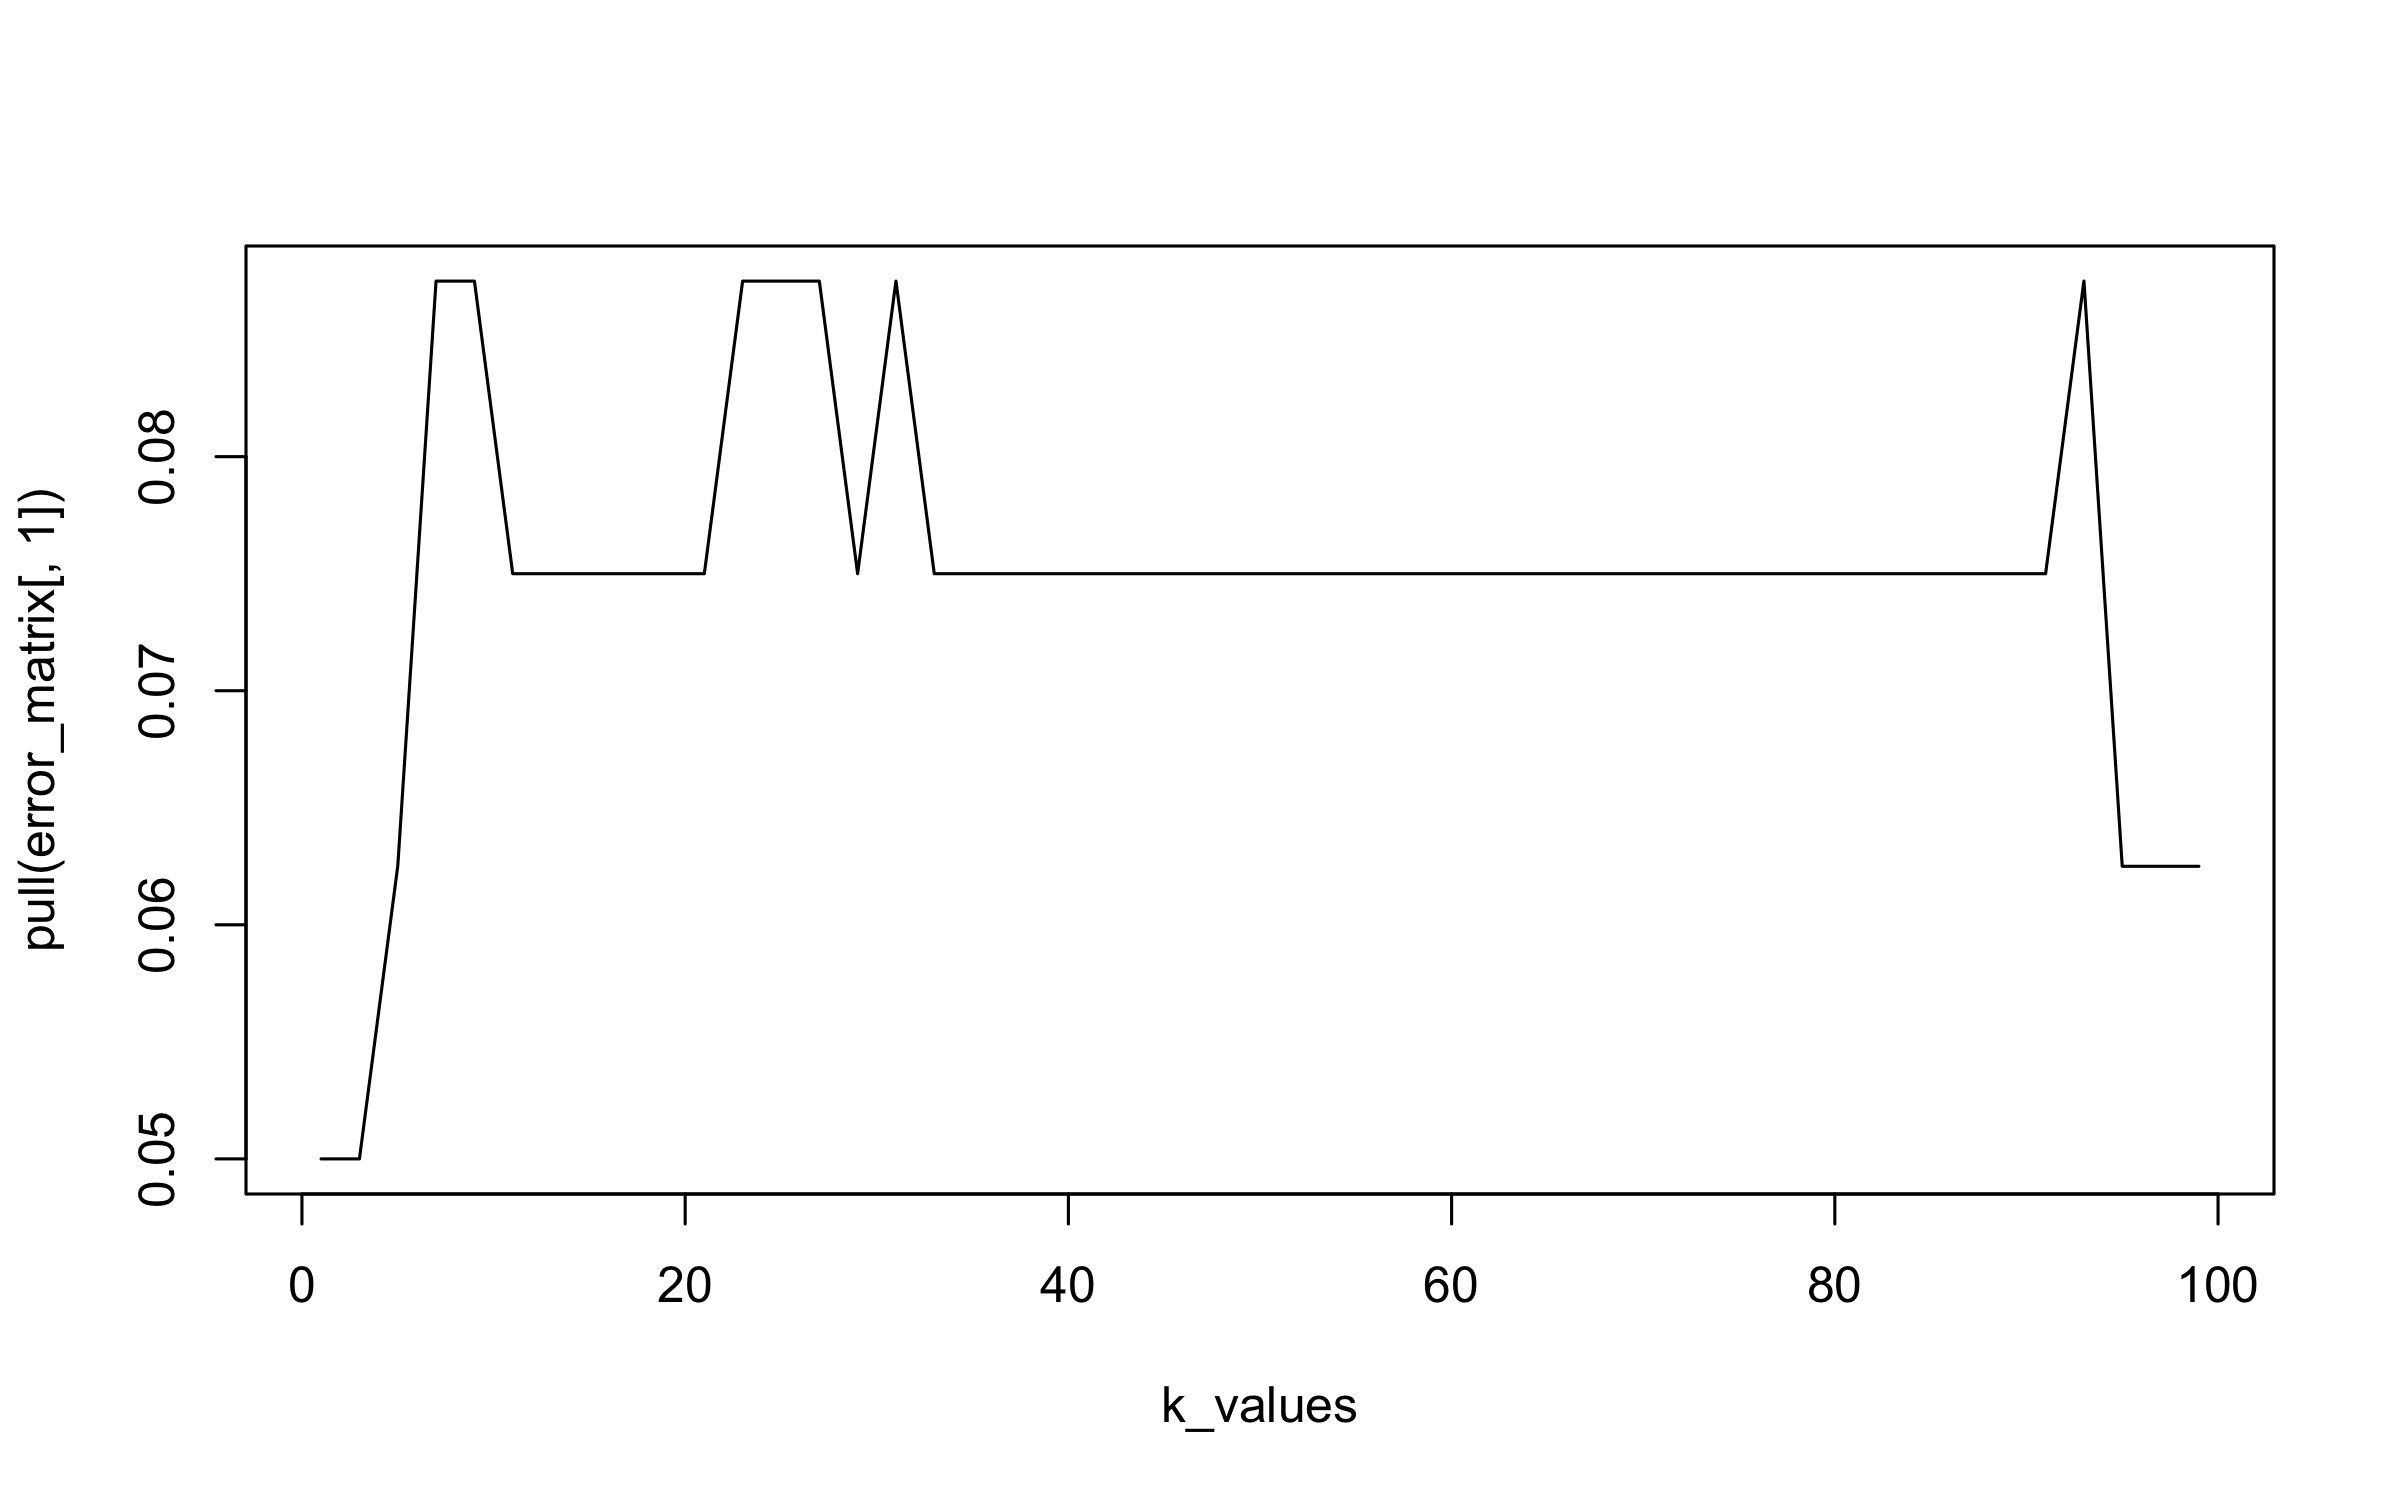

In [56]:
plot(k_values, pull(error_matrix[,1]), type='l') # pull is for formatting

Let's now do this for all our "folds":

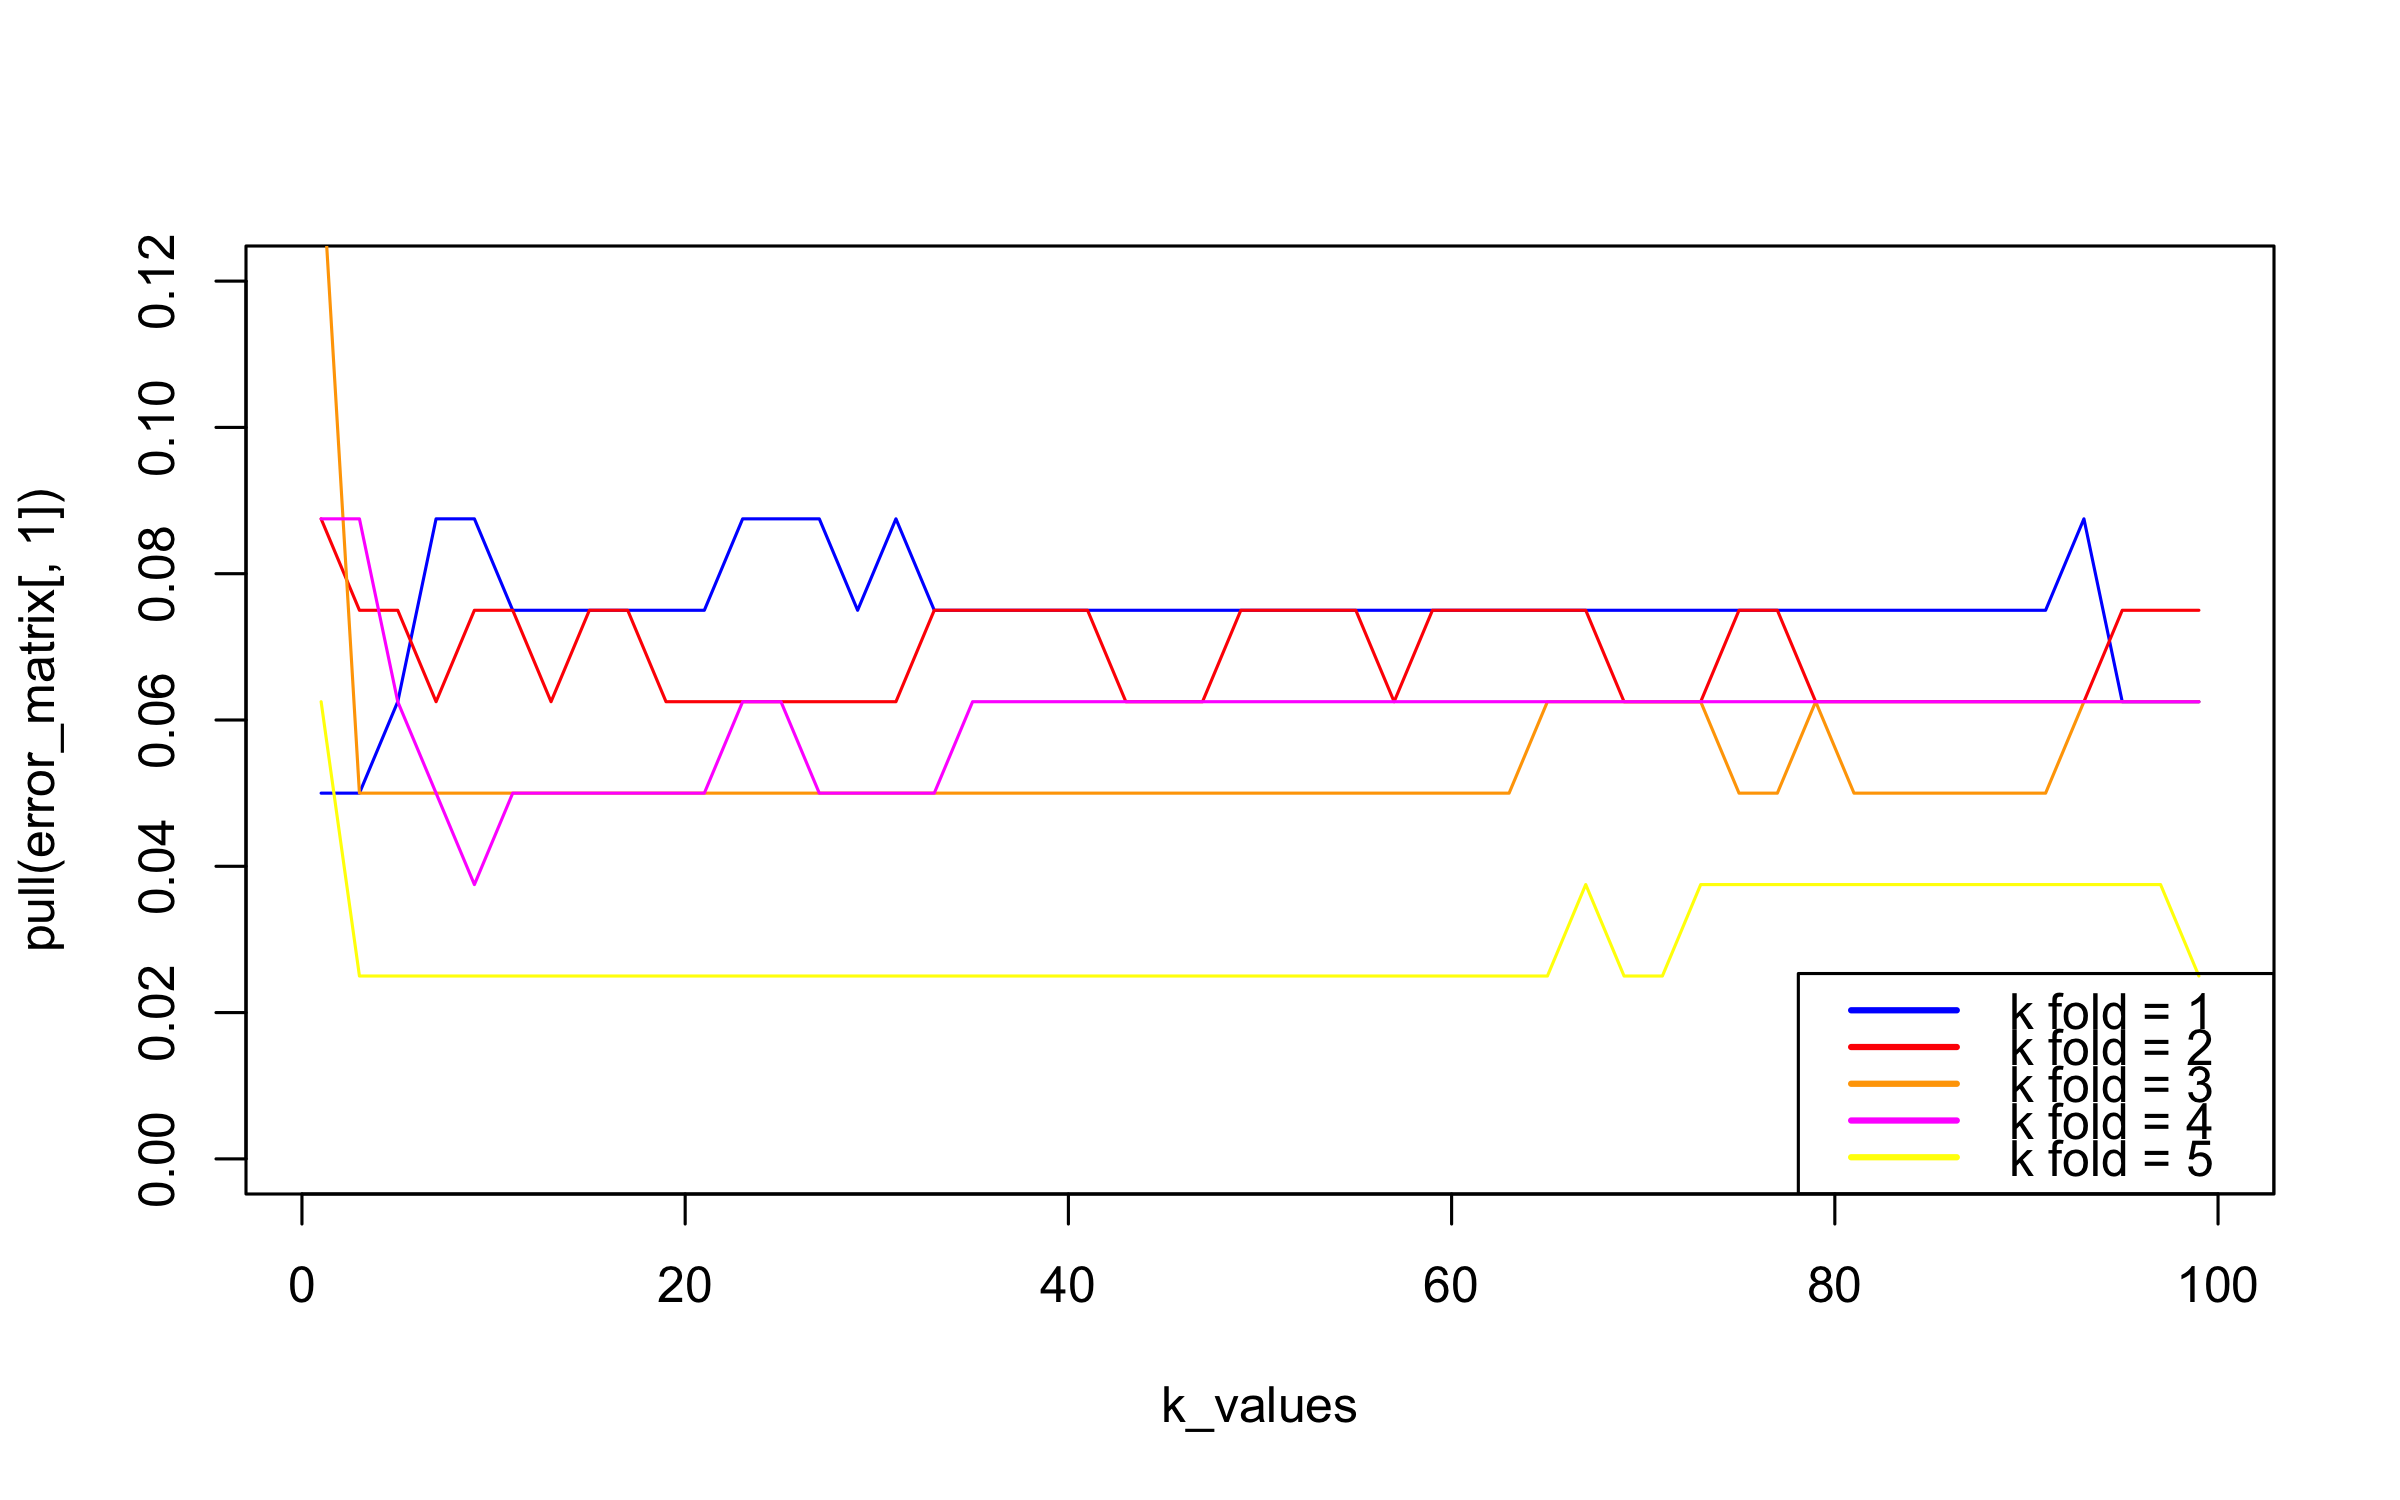

In [57]:
color = c("blue", "red", "orange", "magenta", "yellow") # choose color for each fold

plot(k_values, pull(error_matrix[,1]), type='l', col=color[1], ylim=c(0.0, 0.12)) # plot the first one

lnames = c("k fold = 1") # start an array of labels for our legend

# now do all the remaining folds, add to legend
for(i in 2:k_folds_k){
  lines(k_values, pull(error_matrix[,i]), col=color[i])
  lnames = append(lnames, paste("k fold =",toString(i)))
}

legend("bottomright", lnames, col=color, lwd=2)

We can see in general that all of these CV errors tend to increase at both the low and high k ends, though they have different overall noramlizations.

Ok, now, let's compute the mean CV error for each KNN k we'll do this across each row:

In [58]:
cv_mean = rowMeans(error_matrix[-(k_folds_k+1)])

Note, the -(k_folds_k+1) is to not include the k labeling column.

Let's add this to our plot!

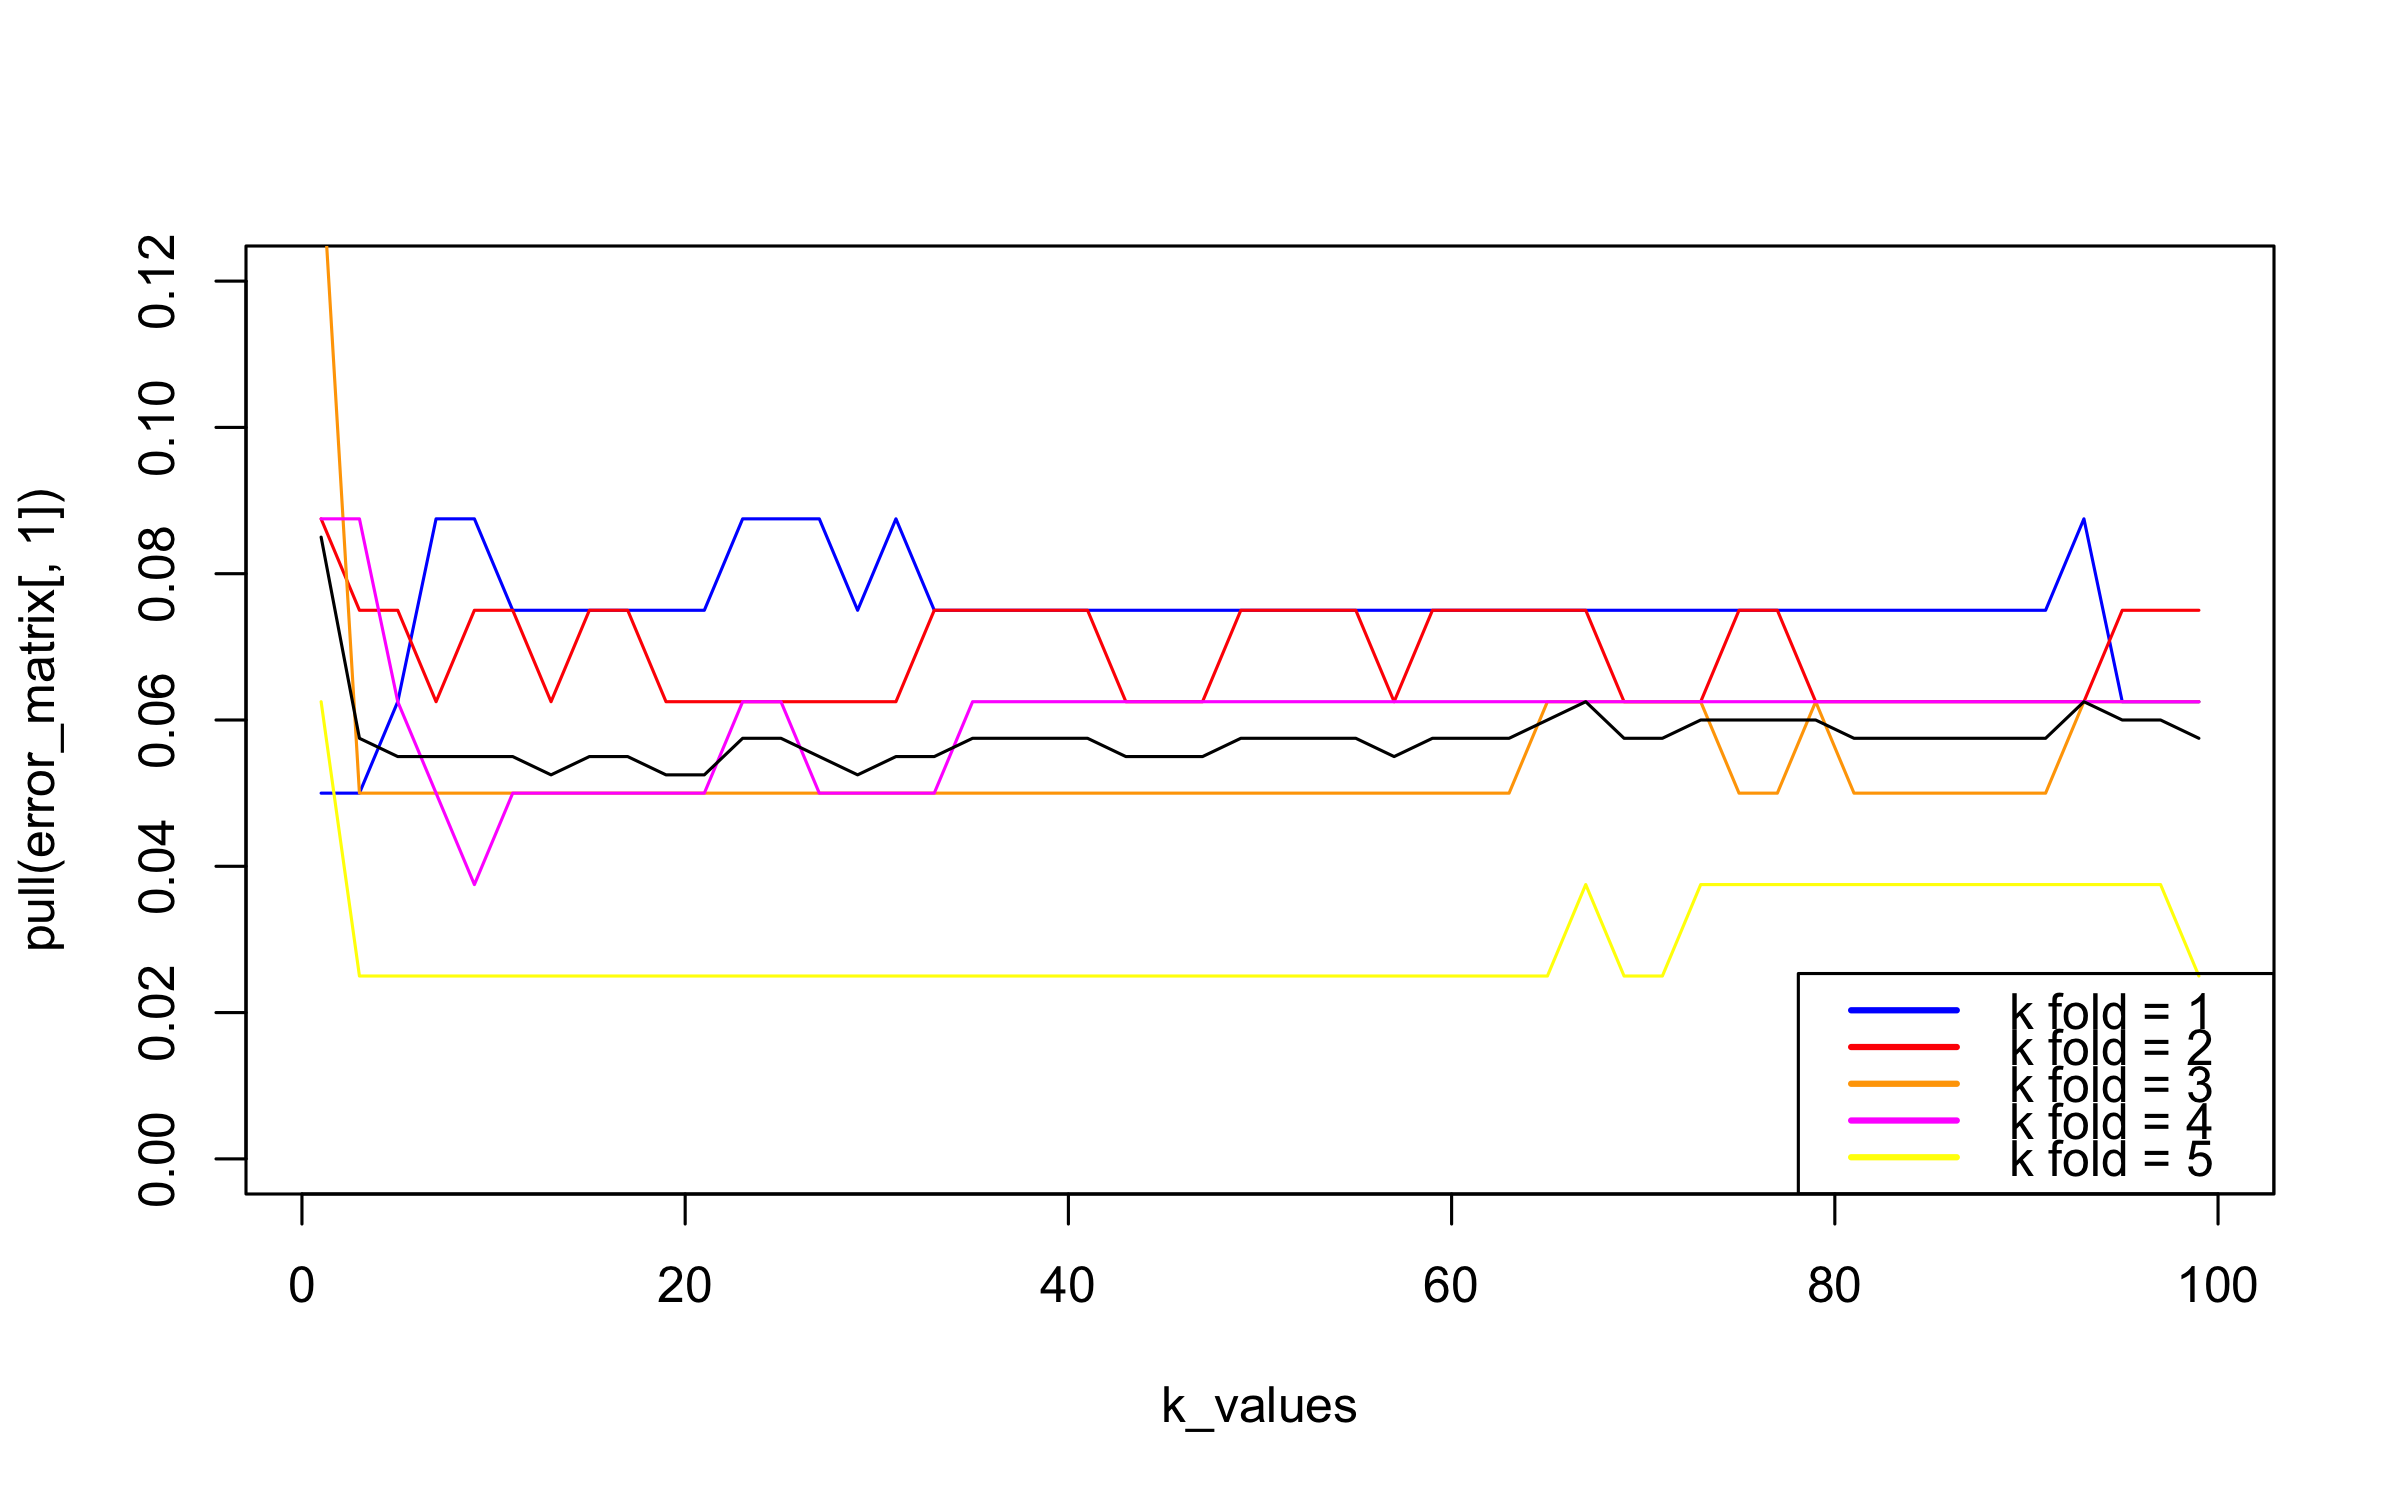

In [59]:
# Orig plot:
plot(k_values, pull(error_matrix[,1]), type='l', col=color[1], ylim=c(0.0, 0.12)) # plot the first one

# now do all the remaining folds, add to legend
for(i in 2:k_folds_k){
  lines(k_values, pull(error_matrix[,i]), col=color[i])
}

legend("bottomright", lnames, col=color, lwd=2)

# overplot the row mean across all folds
lines(k_values, cv_mean, col='black')

We can also see how this changes with different seeds **GO BACK AND DO ON YOUR OWN -- go back and set to original seed & re-run**

Ok, let's plot this with the tst and tr errors we calculated before to compare:

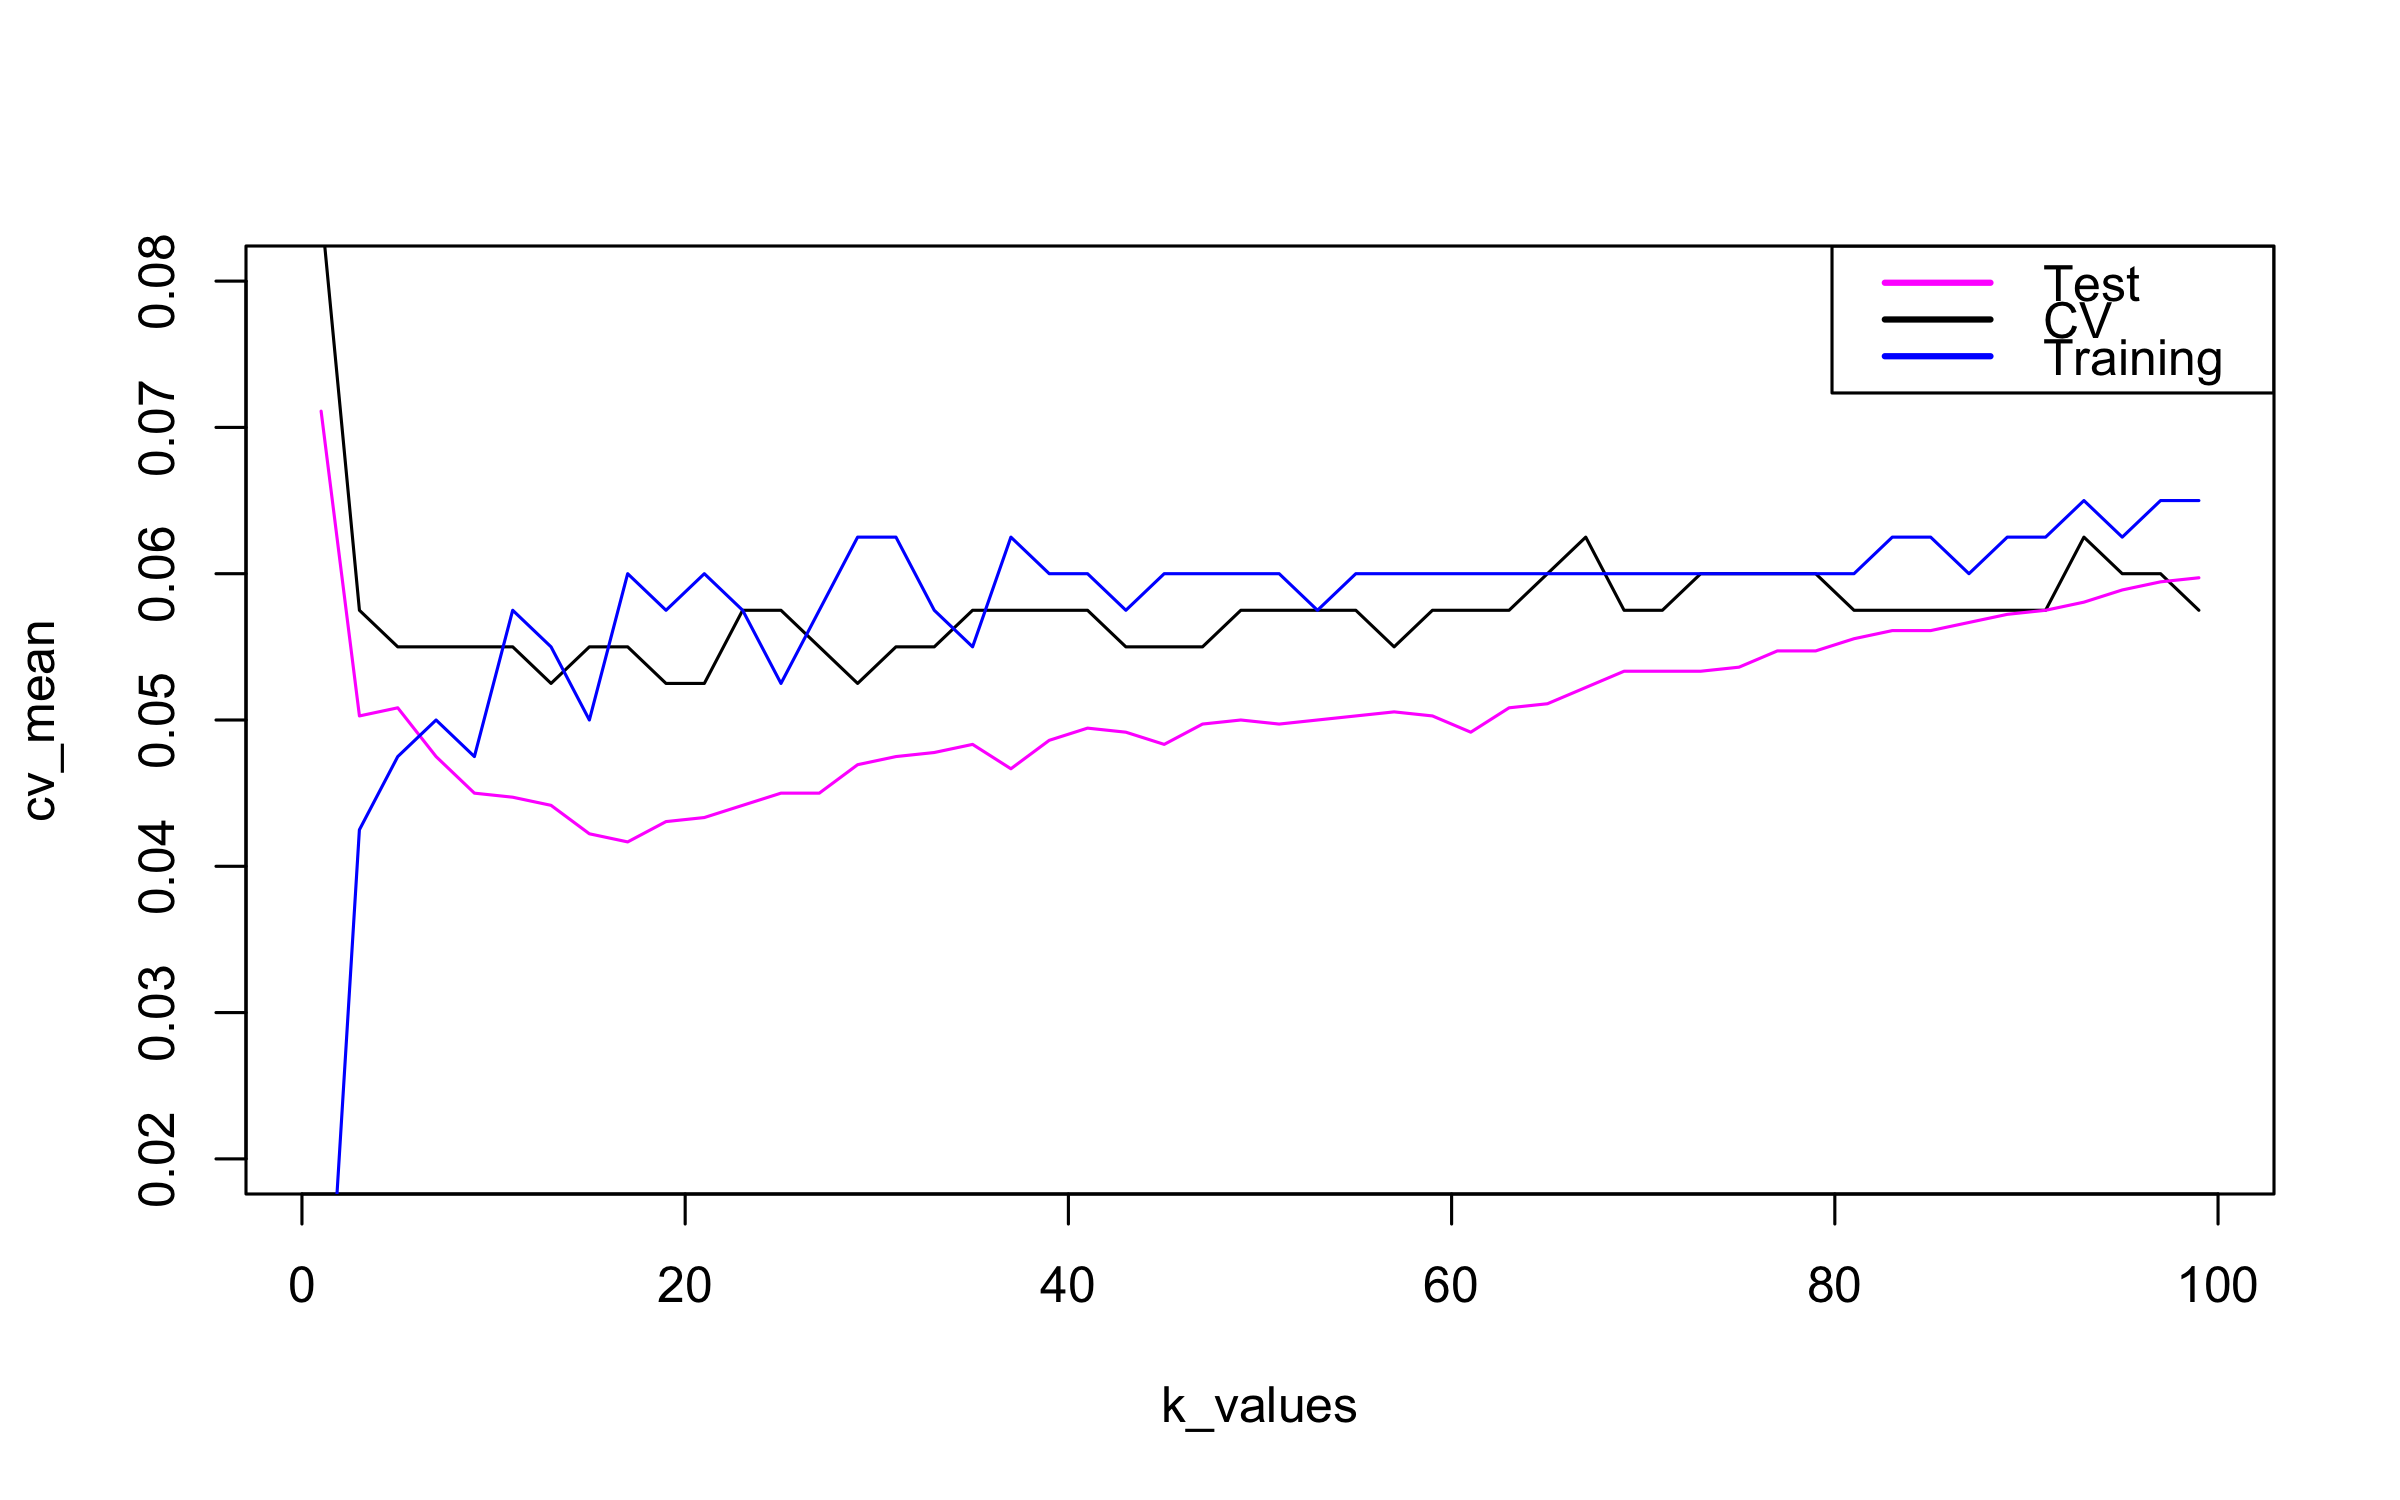

In [60]:
plot(k_values, cv_mean, col='black', type='l', ylim=c(0.02, 0.08))
# since we originally calcualted these with a 
# differnt set of KNN k's lets re calculate
tr = c()
tst = c()
# now lets loop
for( i in 1:num_k ){
  # here: our training data is our sample, 
  #  and our test_data is our actual distribution
  errs = get_knn_error_rates(train_data, test_data, k_values[i])
  tr = append(tr, errs$tr)
  tst = append(tst, errs$tst)
}

lines(k_values, tst, col="magenta")
lines(k_values, tr, col="blue")

legend("topright", c("Test", "CV", "Training"), col=c("magenta","black","blue"), lwd=2)

Ideally, all the minimums would line up, but of course this is not the case - what we can say is that k between ~10 to 35 seems to be the best choice to pick.  In theory, we should also run this for different random seeds to see what changes, but in the interest of time, we'll move on (or do it if we have time!)

In summary: the black line we calculated using CV is similar to the actual test error rate from our simulated population, in magenta.

## 5. CV with tuning function

Now that we know how the mechanism works in detail, we can also just use a built in function to do this for us:

In [61]:
#install.packages("e1071") # run once

OR if you're in Anaconda, you can do in the conda environment by installing `r-e1071`.

In [62]:
library("e1071")


Attaching package: ‘e1071’


The following object is masked from ‘package:flexclust’:

    bclust




To use the functions here to do CV for us, we need to do some more formatting and pass vectors only instead of the nicely formatting tibble data of `train_data`.  We'll `pull` these vectors:

In [63]:
y = pull(train_data[,3]) # grab 3rd column, format into vector
x1 = pull(train_data[,1]) # pull 
x2 = pull(train_data[,2])

And bind `x1` and `x2` into a set of columns:

In [64]:
x = cbind(x1, x2)

Let's look at this data:

In [65]:
head(y)

[1] 1  1  1  -1 1  1 
Levels: -1 1

In [66]:
head(x)

x1          x2        
[1,]  0.38965743 -1.0773363
[2,]  1.80698776 -0.7169107
[3,]  1.20809564 -0.4012162
[4,] -0.05827145 -0.7726721
[5,]  0.58869241  0.4911179
[6,]  0.18112672 -0.7940458

We'll use the `tune.knn` function to do a CV for us, automatically:

In [67]:
knn_kfold = tune.knn(x=x, y=y, k=1:50)

In [68]:
summary(knn_kfold)


Parameter tuning of ‘knn.wrapper’:

- sampling method: 10-fold cross validation 

- best parameters:
  k
 30

- best performance: 0.055 

- Detailed performance results:
    k  error dispersion
1   1 0.0850 0.03944053
2   2 0.0775 0.04779877
3   3 0.0650 0.04743416
4   4 0.0825 0.04571956
5   5 0.0675 0.04417453
6   6 0.0675 0.03736085
7   7 0.0600 0.03944053
8   8 0.0575 0.03736085
9   9 0.0625 0.03952847
10 10 0.0650 0.03574602
11 11 0.0600 0.03944053
12 12 0.0575 0.04257347
13 13 0.0600 0.04887626
14 14 0.0575 0.04257347
15 15 0.0675 0.04721405
16 16 0.0625 0.04894725
17 17 0.0600 0.04887626
18 18 0.0625 0.04894725
19 19 0.0625 0.04894725
20 20 0.0625 0.04289846
21 21 0.0650 0.04887626
22 22 0.0600 0.04281744
23 23 0.0600 0.05163978
24 24 0.0625 0.05170697
25 25 0.0625 0.05170697
26 26 0.0600 0.05163978
27 27 0.0625 0.05170697
28 28 0.0625 0.05170697
29 29 0.0625 0.05170697
30 30 0.0550 0.05109903
31 31 0.0600 0.05163978
32 32 0.0600 0.05163978
33 33 0.0625 0.05170697
34 34 0.0625 

We can see that the above does a 10-fold CV measurement it also gives you the "best" k.  You can run this a few times to see that this "best" k changes with different random fold subsets.

We can also specify the number of folds to compare to our previous calculations like so:

In [69]:
knn_kfold_5 = tune.knn(x=x, y=y, k=1:50, 
                       tunecontrol=tune.control(sampling = "cross", cross=k_folds_k))

Let's grab the vector of k-folds and their associated error rate for plotting:

In [70]:
k_k5 = knn_kfold_5$performances$k
err_k5 = knn_kfold_5$performances$error

Let's add this to our plot:

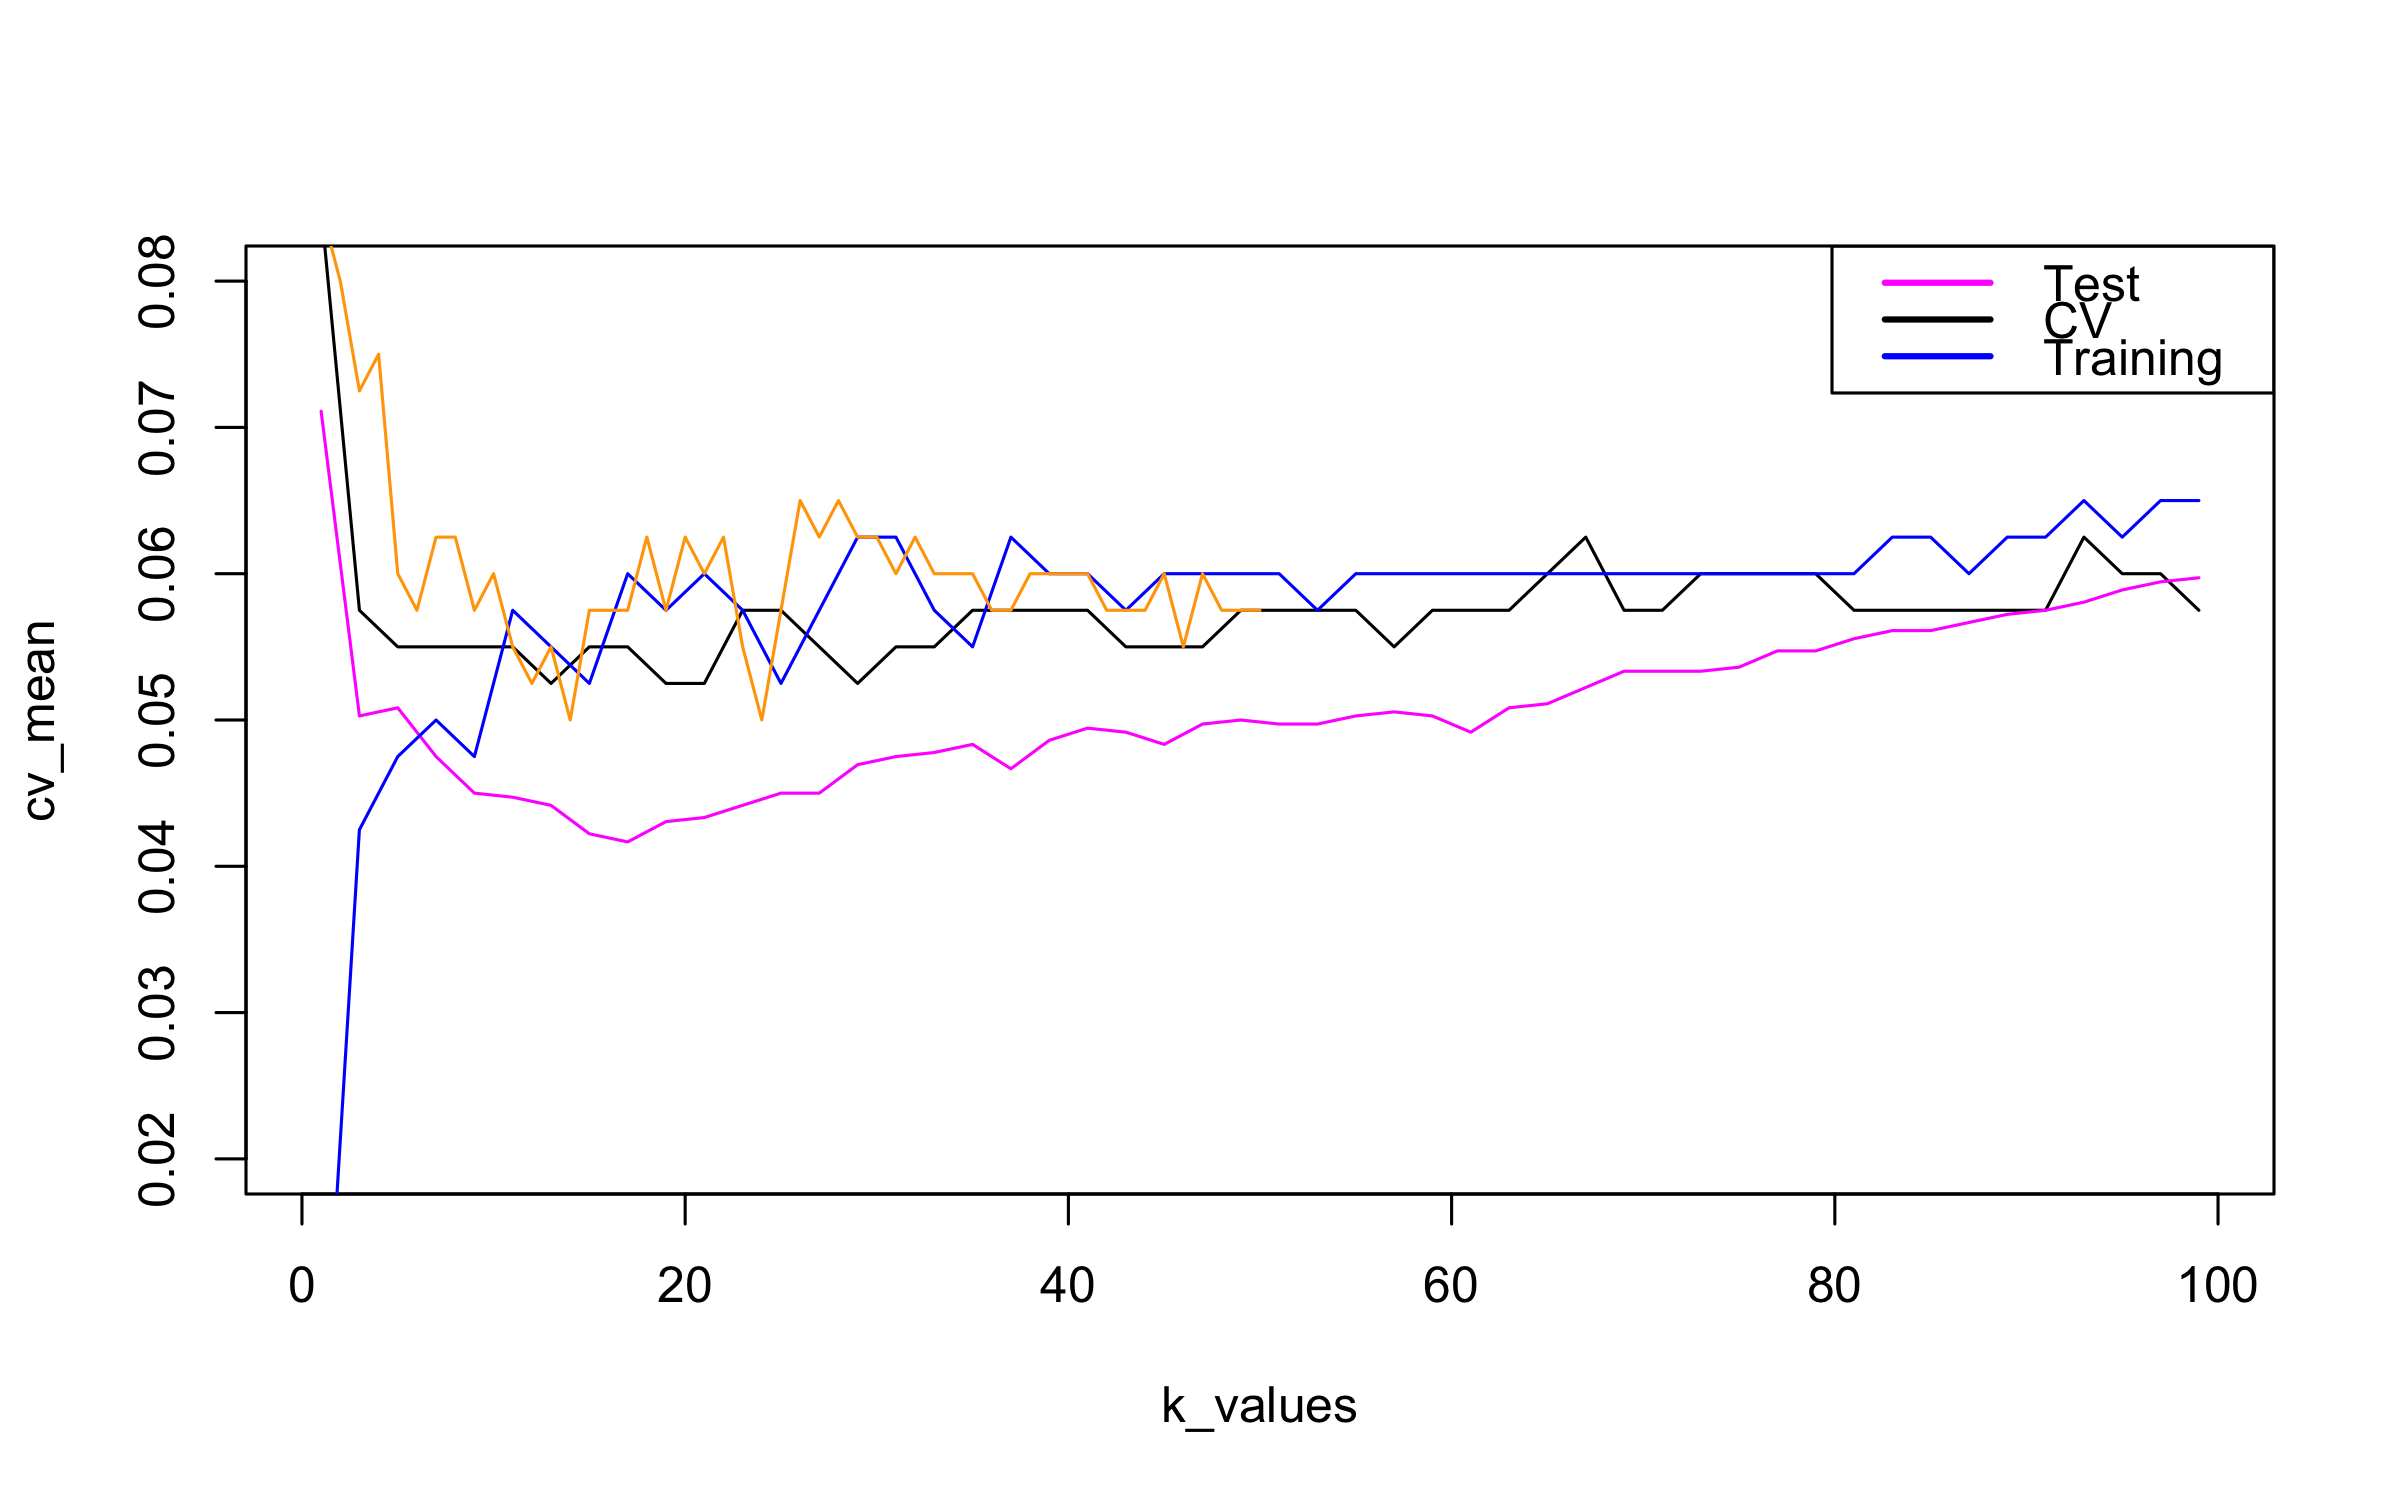

In [71]:
plot(k_values, cv_mean, col='black', type='l', ylim=c(0.02, 0.08))
# since we originally calcualted these with a 
# differnt set of KNN k's lets re calculate
tr = c()
tst = c()
# now lets loop
for( i in 1:num_k ){
  # here: our training data is our sample, 
  #  and our test_data is our actual distribution
  errs = get_knn_error_rates(train_data, test_data, k_values[i])
  tr = append(tr, errs$tr)
  tst = append(tst, errs$tst)
}

lines(k_values, tst, col="magenta")
lines(k_values, tr, col="blue")

legend("topright", c("Test", "CV", "Training"), col=c("magenta","black","blue"), lwd=2)

# addition:
lines(k_k5, err_k5, col="orange")

Note, we can also simply do:

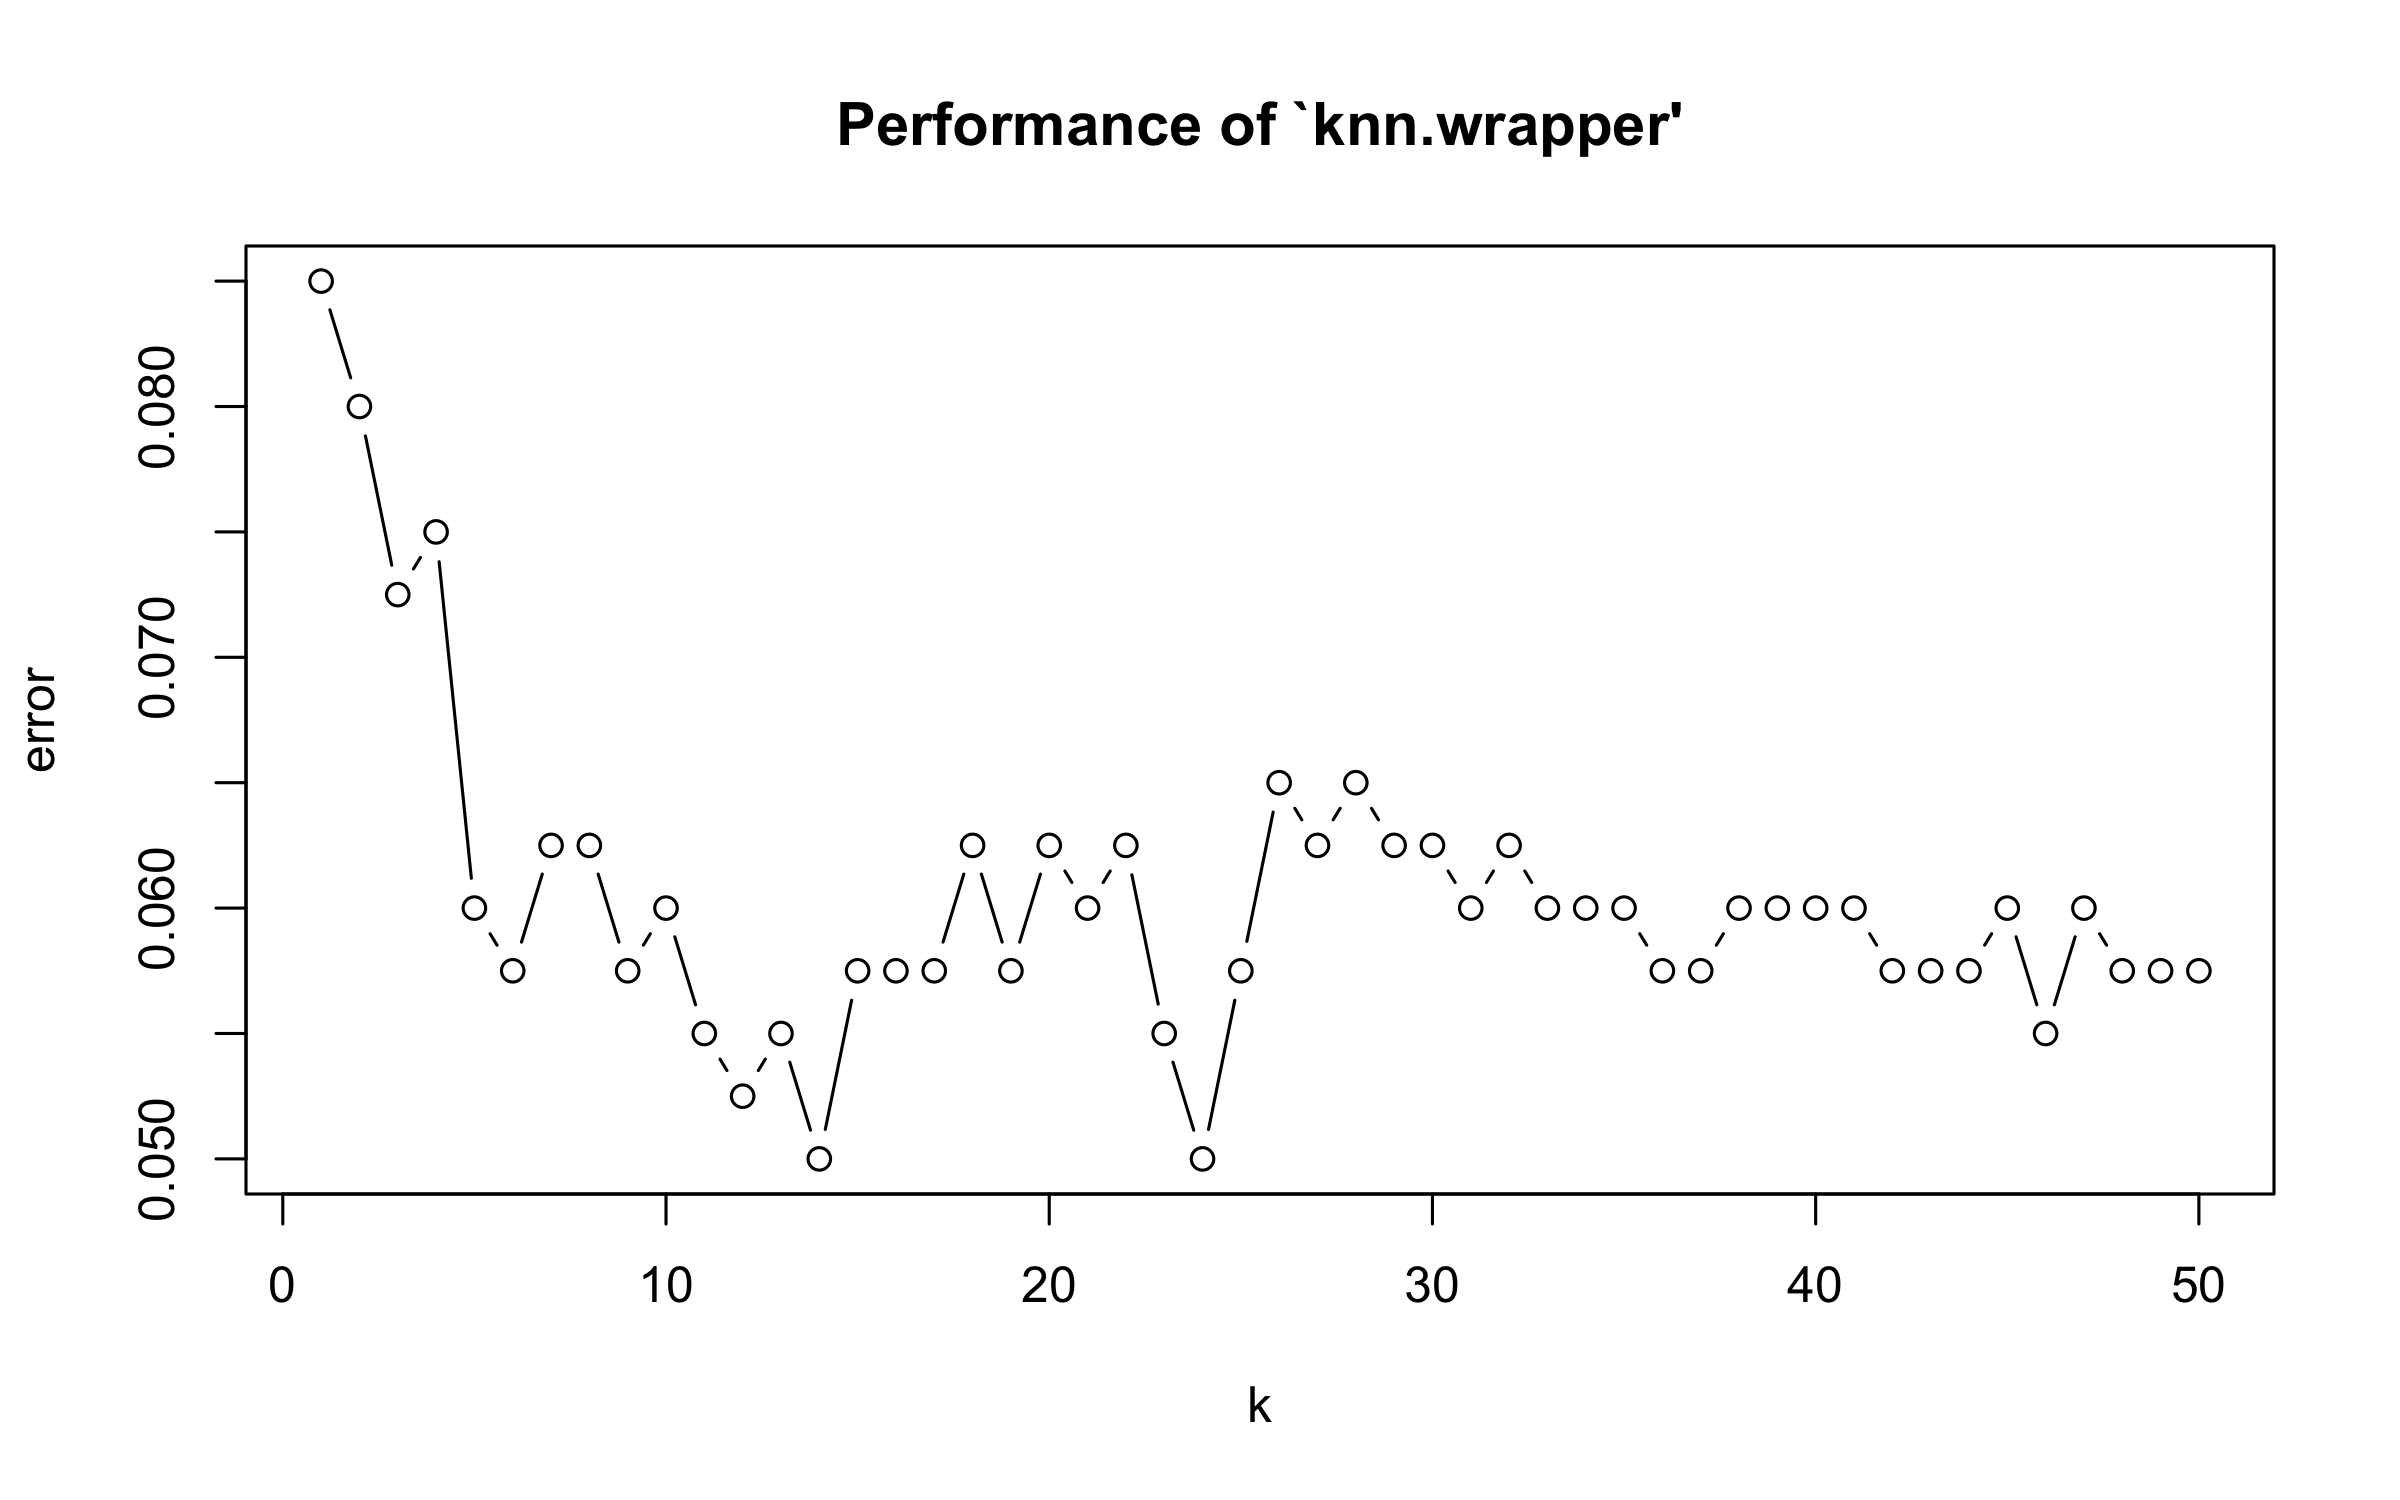

In [72]:
plot(knn_kfold_5)

## 6. TO SLIDES TO TALK ABOUT BOOTSTRAPPING

## 7. Bootstrapping with tuning function

Now, we could go through the whole example again of doing this by hand, or now that we know about the tuning function in R, let's just do that!

In [73]:
knn_boot = tune.knn(x = x, y = y, k = 1:50,tunecontrol=tune.control(sampling = "boot") )

In [74]:
summary(knn_boot)


Parameter tuning of ‘knn.wrapper’:

- sampling method: bootstrapping 

- best parameters:
  k
 29

- best performance: 0.05861472 

- Detailed performance results:
    k      error dispersion
1   1 0.08836221 0.01839837
2   2 0.09320024 0.01440174
3   3 0.08576125 0.01593063
4   4 0.08370306 0.01860745
5   5 0.07865560 0.01985982
6   6 0.07924384 0.01917424
7   7 0.07619925 0.02119539
8   8 0.07124156 0.02418513
9   9 0.06625885 0.02674775
10 10 0.07016691 0.02717808
11 11 0.06501106 0.02422677
12 12 0.06172214 0.02338021
13 13 0.06230357 0.02239904
14 14 0.06224357 0.01948172
15 15 0.06290584 0.02255391
16 16 0.06286024 0.02105404
17 17 0.06302120 0.02139992
18 18 0.06224320 0.02388627
19 19 0.06112872 0.01917809
20 20 0.06038407 0.02236755
21 21 0.06103010 0.01963634
22 22 0.05922167 0.01869403
23 23 0.06235711 0.01948413
24 24 0.06043162 0.01900984
25 25 0.06231655 0.01942721
26 26 0.06297707 0.01804064
27 27 0.06235950 0.01826267
28 28 0.05986477 0.01972187
29 29 0.05861472 0.0190

If we run this a few times we see that we get slightly different k's.

Let's compare this to our k-folds above, first by grabbing the bootstrapping k-vector and error rates...

In [75]:
k_boot = knn_boot$performances$k
err_boot = knn_boot$performances$error

...and then re-plotting and adding our bootstrapping error rate:

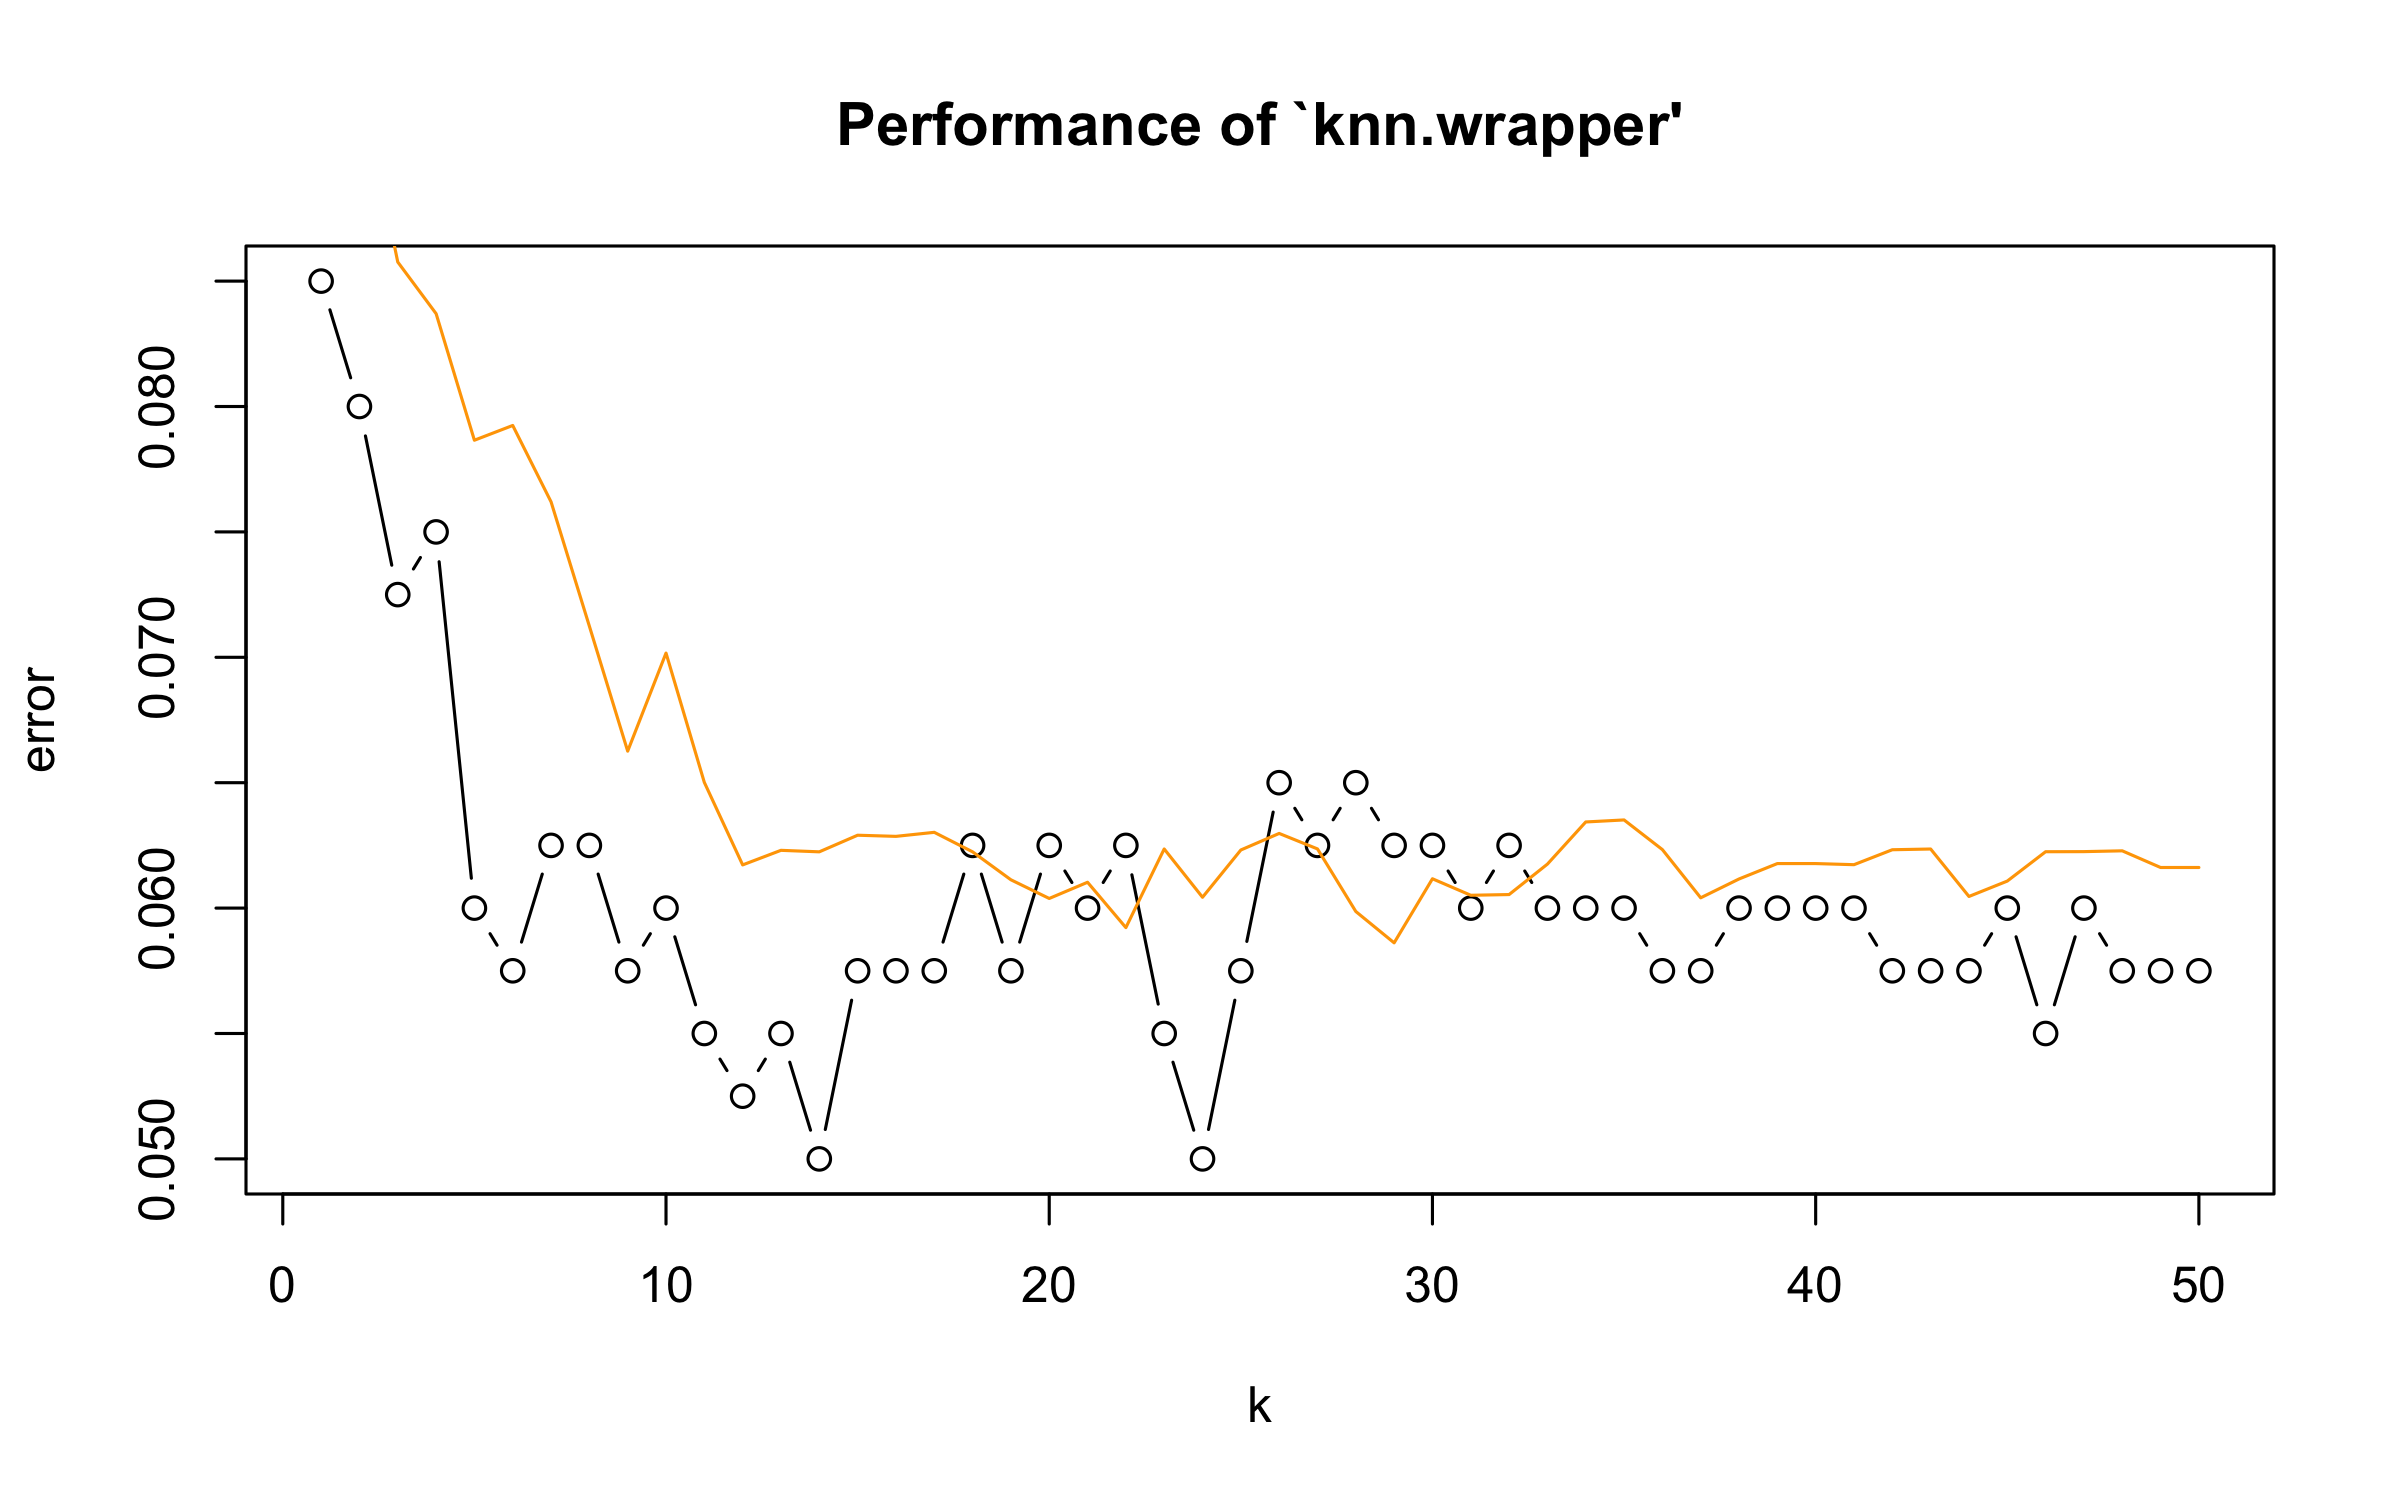

In [76]:
plot(knn_kfold_5) # knn plot

# line from bootstrapping:
lines(k_boot, err_boot, col="orange")

Again, because it is a different method, the normalization is slightly different, but overall the shape is the same.


With either method, we find k $\sim$20-30 minimizes the error.  So, let's go all the way back to plotting our KNN classification and take a look with k$\sim$20-30:

In [77]:
my_k_choice = 25

Let's use this k to make a prediction using KNN:

In [78]:
knn_train_prediction = knn(train.X, new_grid.X, train_data$y, k=my_k_choice, prob=T)

And grab the probability to plot with the plotting function like before:

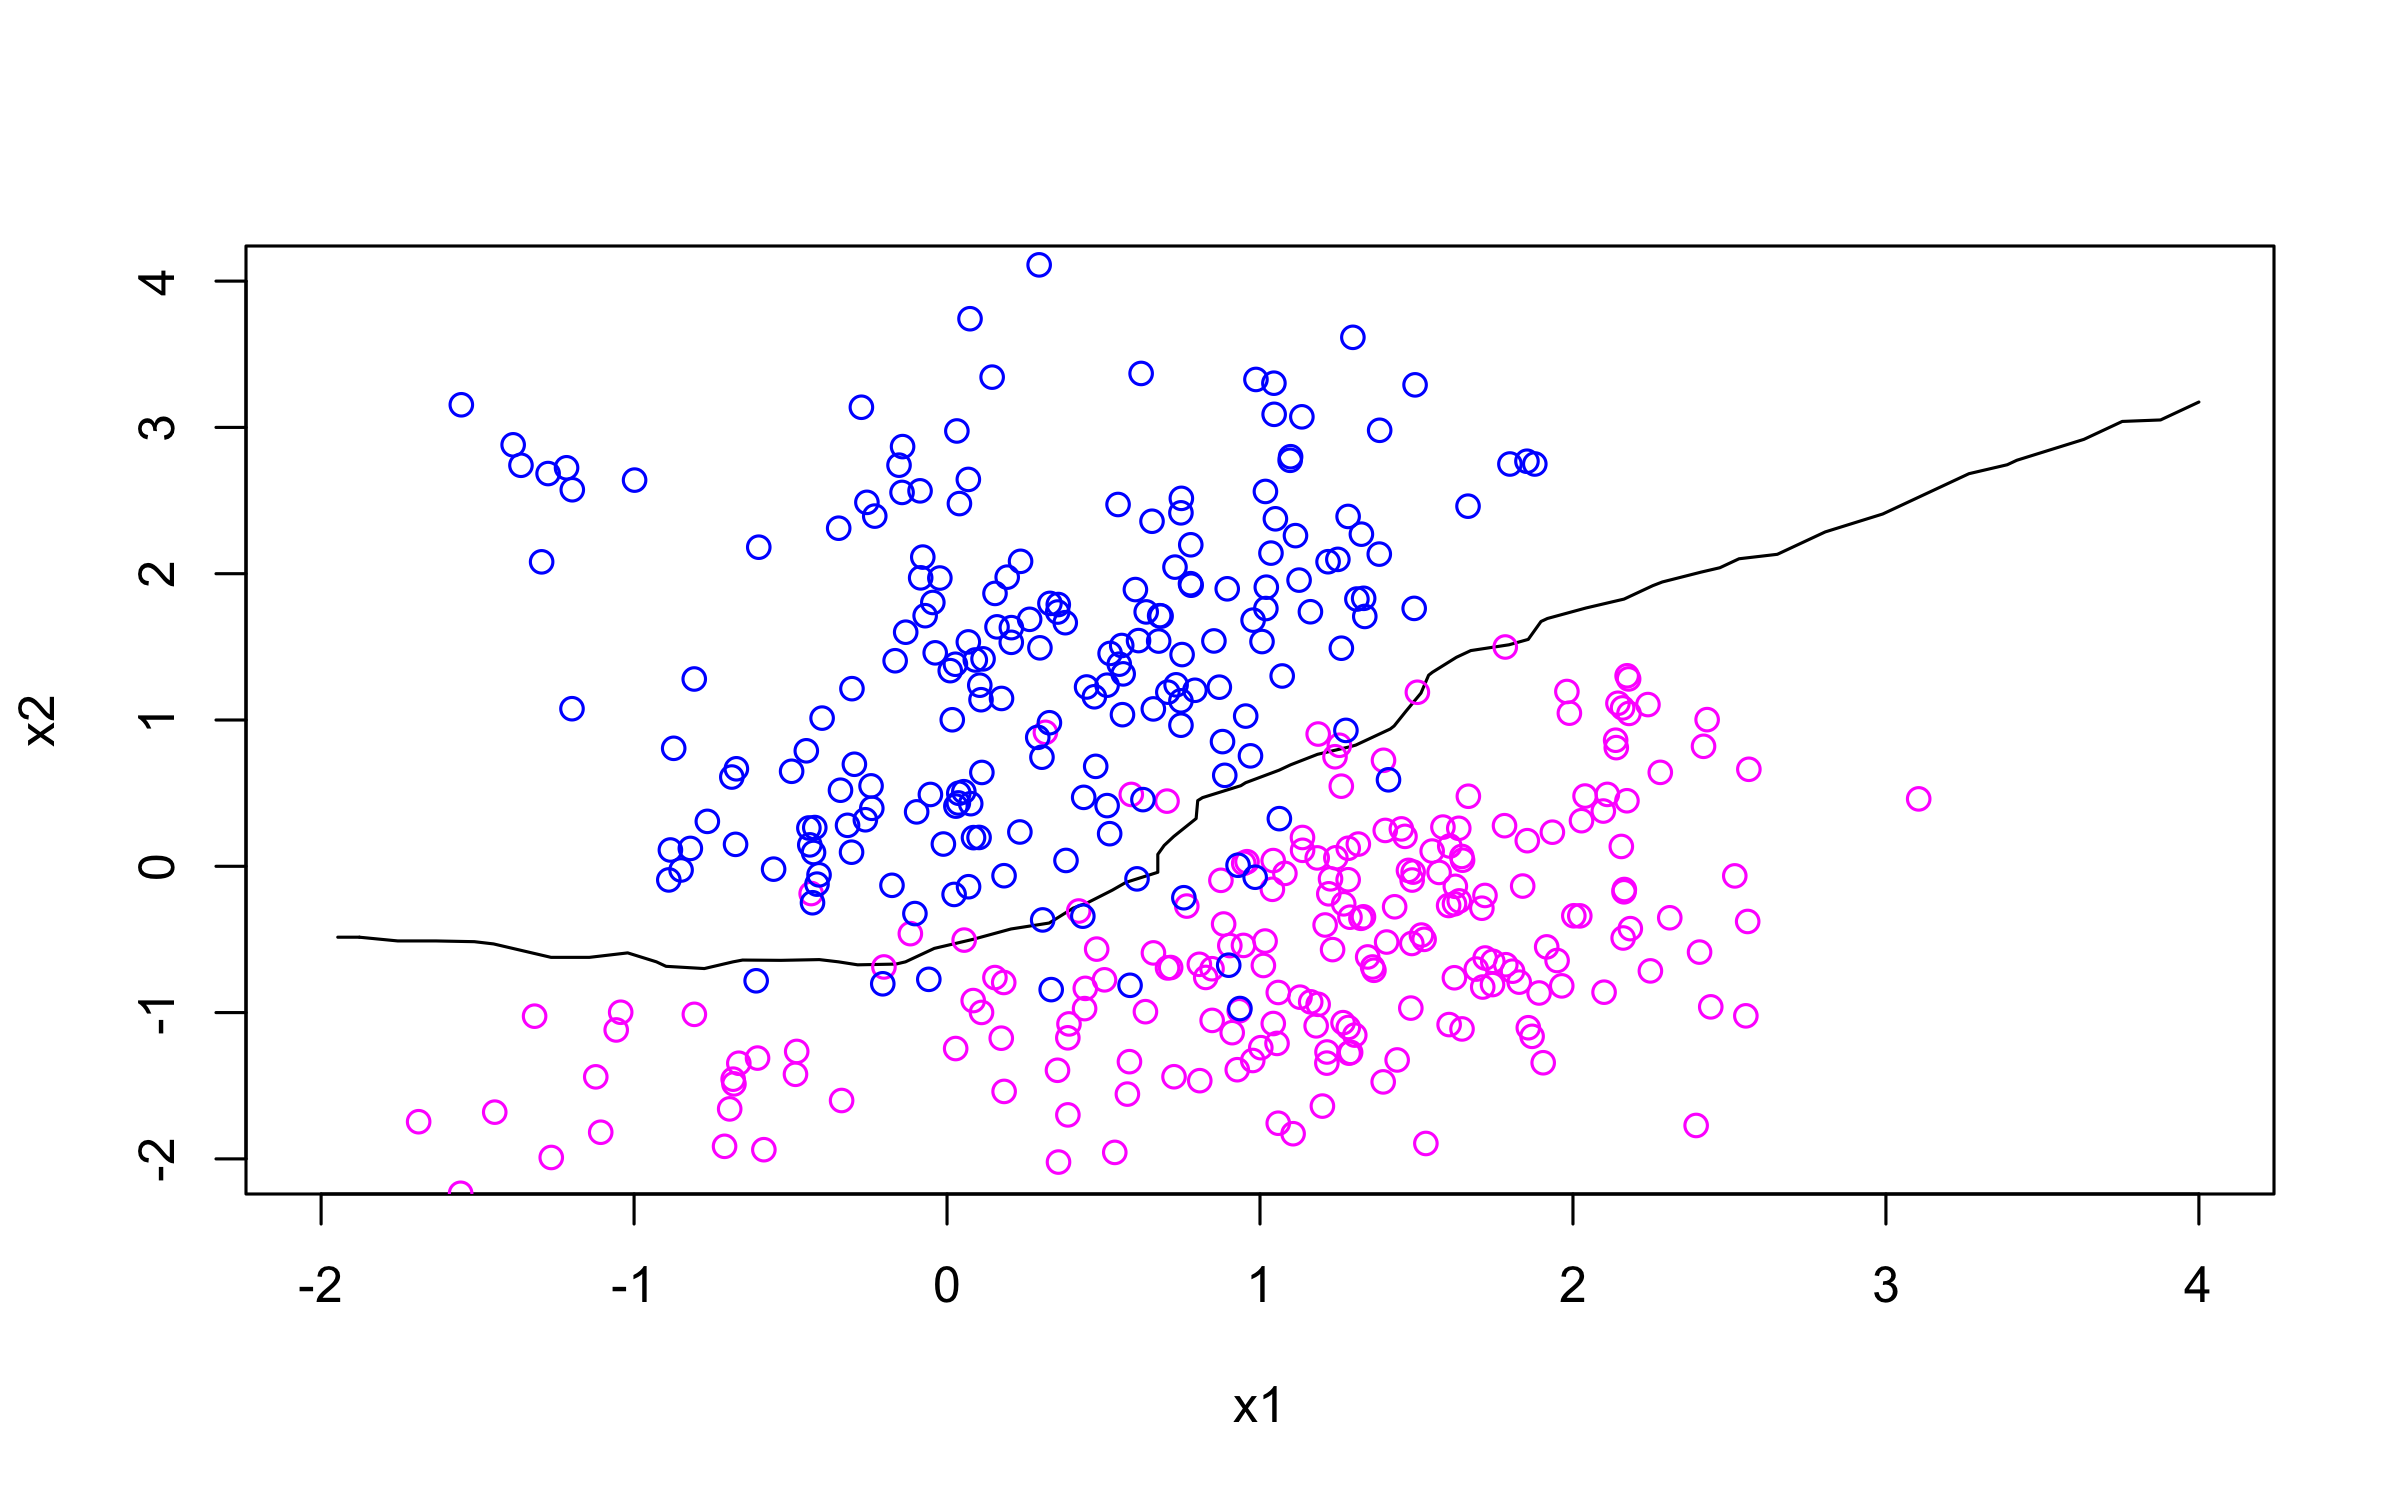

In [79]:
prob = attr(knn_train_prediction, "prob")

plot2dProbKNN(knn_train_prediction, train_data, grid_size, prob_cut_off, x1min,x1max, x2min,x2max, prob)

TADAH!!! We did it!  This is our "best" KNN model!